# Analysis of dynamic network ABM
Standard networks, no SDA yet, no social comparison

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import cProfile
import pstats
import mesa
pd.set_option('display.max_colwidth', 10000)
import joblib
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import matplotlib.ticker as mtick
from joblib import Parallel, delayed
import json



In [156]:
from model_no_homophily_dynamic_newdata import ConsumatModel

In [157]:
base_config = {
    'TP_percentage': 0.4,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'kde_models_dir': '/Applications/UNI/Thesis/saved_data/',
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'seed': 42  
}

watts_strogatz_config = base_config.copy()
watts_strogatz_config.update({
    'network_type': 'watts_strogatz',
    'network_params': {
        'n': 1600,
        'k': 8,
        'p': 0.3
    }
})


barabasi_albert_config = base_config.copy()
barabasi_albert_config.update({
    'network_type': 'barabasi_albert',
    'network_params': {
        'n': 1600,
        'm': 8
    }
})

random_regular_config = base_config.copy()
random_regular_config.update({
    'network_type': 'random_regular',
    'network_params': {
        'n': 1600,
        'd': 8
    }
})

holme_kim_config = base_config.copy()
holme_kim_config.update({
    'network_type': 'holme_kim',
    'network_params': {
        'n': 1600,
        'm': 8,
        'p': 0.3
    }
})


network_configs = {
    'Watts-Strogatz': watts_strogatz_config,
    'Barabasi-Albert': barabasi_albert_config,
    'Random Regular': random_regular_config,
    'Holme-Kim': holme_kim_config
}

In [159]:
tp_percentages = np.arange(0, 1.05, 0.05)
num_steps = 10
all_results = {network: {} for network in network_configs}
final_adoption_rates = {network: [] for network in network_configs}

def collect_simulation_data(model, num_steps):
    collected_data = {
        'Step': [],
        'Adoption Rate': [],
        'Avg_F_Satisfaction': [],
        'Avg_S_Satisfaction': [],
        'Avg_P_Satisfaction': [],
        'Avg_F_Uncertainty': [],
        'Avg_S_Uncertainty': [],
        'Avg_P_Uncertainty': []
    }

    for step in tqdm(range(num_steps), desc='Simulation Progress'):
        model.step()
        collected_data['Step'].append(step)
        collected_data['Adoption Rate'].append(model.calculate_true_price_adoption_rate())
        collected_data['Avg_F_Satisfaction'].append(np.mean([agent.F_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_S_Satisfaction'].append(np.mean([agent.S_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_P_Satisfaction'].append(np.mean([agent.P_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_F_Uncertainty'].append(np.mean([agent.F_uncertainty for agent in model.schedule.agents]))
        collected_data['Avg_S_Uncertainty'].append(np.mean([agent.S_uncertainty for agent in model.schedule.agents]))
        collected_data['Avg_P_Uncertainty'].append(np.mean([agent.P_uncertainty for agent in model.schedule.agents]))

    model_data = pd.DataFrame(collected_data)
    return model_data

def plot_metric(data, metric, ylabel, filename, scale_as_percentage=False):
    plt.figure(figsize=(15, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, len(data)))

    for color, (tp, df) in zip(colors, data.items()):
        tp_percentage_label = f'{tp * 100:.1f}%'  # Convert TP to percentage for the legend
        if scale_as_percentage:
            plt.plot(df['Step'], df[metric], label=tp_percentage_label, color=color, marker='o')
        else:
            plt.plot(df['Step'], df[metric], label=tp_percentage_label, color=color, marker='o')

    plt.xlabel('Step', fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.legend(title='TP Percentage', fontsize=12)
    plt.grid(True)

    if scale_as_percentage:
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

    
    plt.savefig(f'nohomophily_{filename}.png')
    plt.close()

for network_type, config in network_configs.items():
    for tp in tp_percentages:
        config['TP_percentage'] = tp
        model = ConsumatModel(config)
        model_data = collect_simulation_data(model, num_steps)
        all_results[network_type][tp] = model_data
        final_adoption_rate = model_data['Adoption Rate'].iloc[-1]
        final_adoption_rates[network_type].append(final_adoption_rate)

metrics = [
    ('Adoption Rate', 'Adoption Rate (%)'),
    ('Avg_F_Satisfaction', 'Average Financial Satisfaction'),
    ('Avg_S_Satisfaction', 'Average Social Satisfaction'),
    ('Avg_P_Satisfaction', 'Average Personal Satisfaction'),
    ('Avg_F_Uncertainty', 'Average Financial Uncertainty'),
    ('Avg_S_Uncertainty', 'Average Social Uncertainty'),
    ('Avg_P_Uncertainty', 'Average Personal Uncertainty')
]

for network_type, data in all_results.items():
    for metric, ylabel in metrics:
        plot_metric(data, metric, ylabel, f'{network_type.lower().replace(" ", "_")}_{metric.lower().replace(" ", "_")}', False)

# Additional plot for final adoption rates
for network_type, rates in final_adoption_rates.items():
    plt.figure(figsize=(12, 10))
    plt.plot(tp_percentages*100, rates, marker='o')
    plt.xlabel('TP introduction percentage (%)', fontsize=14)
    plt.ylabel('Final True Price Adoption Rate (%)', fontsize=14)
    plt.ylim(0, 100)
    plt.grid(True)
    plt.savefig(f'no_homophily_final_true_price_adoption_rate_{network_type.lower().replace(" ", "_")}.png')
    plt.close()



Simulation Progress: 100%|██████████| 10/10 [00:28<00:00,  2.84s/it]


In [131]:
def run_simulation(model, num_steps):
    adoption_rates = []
    network_metrics = {
        'Average Degree': [],
        'Variance of Degree': [],
        'Average Clustering': [],
        'Average Path Length': []
    }

    for _ in tqdm(range(num_steps), desc='Simulation Progress'):
        model.step()
        current_adoption_rate = model.calculate_true_price_adoption_rate()
        adoption_rates.append(current_adoption_rate)

        degrees = [deg for n, deg in model.G.degree()]
        avg_degree = np.mean(degrees)
        var_degree = np.var(degrees)

        #print(f"Degrees: {degrees}")  # Debug statement
        #print(f"Avg Degree: {avg_degree}, Var Degree: {var_degree}")  # Debug statement

        network_metrics['Average Degree'].append(avg_degree)
        network_metrics['Variance of Degree'].append(var_degree)
        network_metrics['Average Clustering'].append(nx.average_clustering(model.G))
        network_metrics['Average Path Length'].append(nx.average_shortest_path_length(model.G) if nx.is_connected(model.G) else None)

    model_data = model.datacollector.get_model_vars_dataframe()
    agent_data = model.datacollector.get_agent_vars_dataframe()
    model_data['Adoption Rates'] = adoption_rates

    return model_data, agent_data, network_metrics


def run_multiple_simulations(config, num_steps, num_simulations):
    all_simulation_data = []
    all_network_metrics = []
    
    for _ in range(num_simulations):
        model = ConsumatModel(config)
        model_data, agent_data, network_metrics = run_simulation(model, num_steps)
        all_simulation_data.append(model_data)
        all_network_metrics.append(network_metrics)
        
    return all_simulation_data, all_network_metrics

def plot_adoption_rates(simulation_data, config_name):
    plt.figure(figsize=(10, 6))
    for sim_data in simulation_data:
        plt.plot(sim_data['Adoption Rates'],  marker='o')  
    plt.title(f'True Price Adoption Rate Over Iterations for {config_name}')
    plt.xlabel('Iteration')
    plt.ylabel('True Price Adoption Rate (%)')
    plt.ylim(0,100)
    plt.grid(True)
    plt.show()

def plot_network_metrics(network_metrics, config_name):
    steps = range(len(network_metrics['Average Degree']))
    
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    
    axs[0, 0].plot(steps, network_metrics['Average Degree'], marker='o')
    axs[0, 0].set_title('Average Degree')
    axs[0, 0].set_xlabel('Iteration')
    axs[0, 0].set_ylabel('Value')
    
    axs[0, 1].plot(steps, network_metrics['Variance of Degree'], marker='o')
    axs[0, 1].set_title('Variance of Degree')
    axs[0, 1].set_xlabel('Iteration')
    axs[0, 1].set_ylabel('Value')
    
    axs[1, 0].plot(steps, network_metrics['Average Clustering'], marker='o')
    axs[1, 0].set_title('Average Clustering')
    axs[1, 0].set_xlabel('Iteration')
    axs[1, 0].set_ylabel('Value')
    
    axs[1, 1].plot(steps, network_metrics['Average Path Length'], marker='o')
    axs[1, 1].set_title('Average Path Length')
    axs[1, 1].set_xlabel('Iteration')
    axs[1, 1].set_ylabel('Value')
    
    fig.suptitle(f'Network Metrics for {config_name} Network', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
    
def run_all_simulations(configurations, num_steps, num_simulations):
    results = {}
    simulation_data_results = {}
    for config_name, config in configurations.items():
        print(f"Running simulations for {config_name} network...")
        sim_data, all_network_metrics = run_multiple_simulations(config, num_steps, num_simulations)
        
        avg_network_metrics = {
            'Average Degree': [],
            'Variance of Degree': [],
            'Average Clustering': [],
            'Average Path Length': []
        }

        num_metrics = len(all_network_metrics[0]['Average Degree'])

        for i in range(num_metrics):
            avg_network_metrics['Average Degree'].append(np.mean([metrics['Average Degree'][i] for metrics in all_network_metrics if metrics['Average Degree'][i] is not None]))
            avg_network_metrics['Variance of Degree'].append(np.mean([metrics['Variance of Degree'][i] for metrics in all_network_metrics if metrics['Variance of Degree'][i] is not None]))
            avg_network_metrics['Average Clustering'].append(np.mean([metrics['Average Clustering'][i] for metrics in all_network_metrics if metrics['Average Clustering'][i] is not None]))
            avg_network_metrics['Average Path Length'].append(np.mean([metrics['Average Path Length'][i] for metrics in all_network_metrics if metrics['Average Path Length'][i] is not None]))

        results[config_name] = avg_network_metrics
        simulation_data_results[config_name] = sim_data
        
    return results, simulation_data_results


In [132]:
network_configurations = {
    'Watts-Strogatz': watts_strogatz_config,
    'Barabasi-Albert': barabasi_albert_config,
    'Random Regular': random_regular_config,
    'Holme-Kim': holme_kim_config
}

num_simulations = 1
num_steps = 10

results, simulation_data_results = run_all_simulations(network_configurations, num_steps, num_simulations)


Running simulations for Watts-Strogatz network...


Simulation Progress: 100%|██████████| 10/10 [00:19<00:00,  2.00s/it]
/Users/isabelklennert/opt/anaconda3/envs/thesisenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/isabelklennert/opt/anaconda3/envs/thesisenv/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Running simulations for Barabasi-Albert network...


Simulation Progress: 100%|██████████| 10/10 [00:39<00:00,  3.90s/it]


Running simulations for Random Regular network...


Simulation Progress: 100%|██████████| 10/10 [00:33<00:00,  3.39s/it]


Running simulations for Holme-Kim network...


Simulation Progress: 100%|██████████| 10/10 [00:41<00:00,  4.18s/it]
/Users/isabelklennert/opt/anaconda3/envs/thesisenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/isabelklennert/opt/anaconda3/envs/thesisenv/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


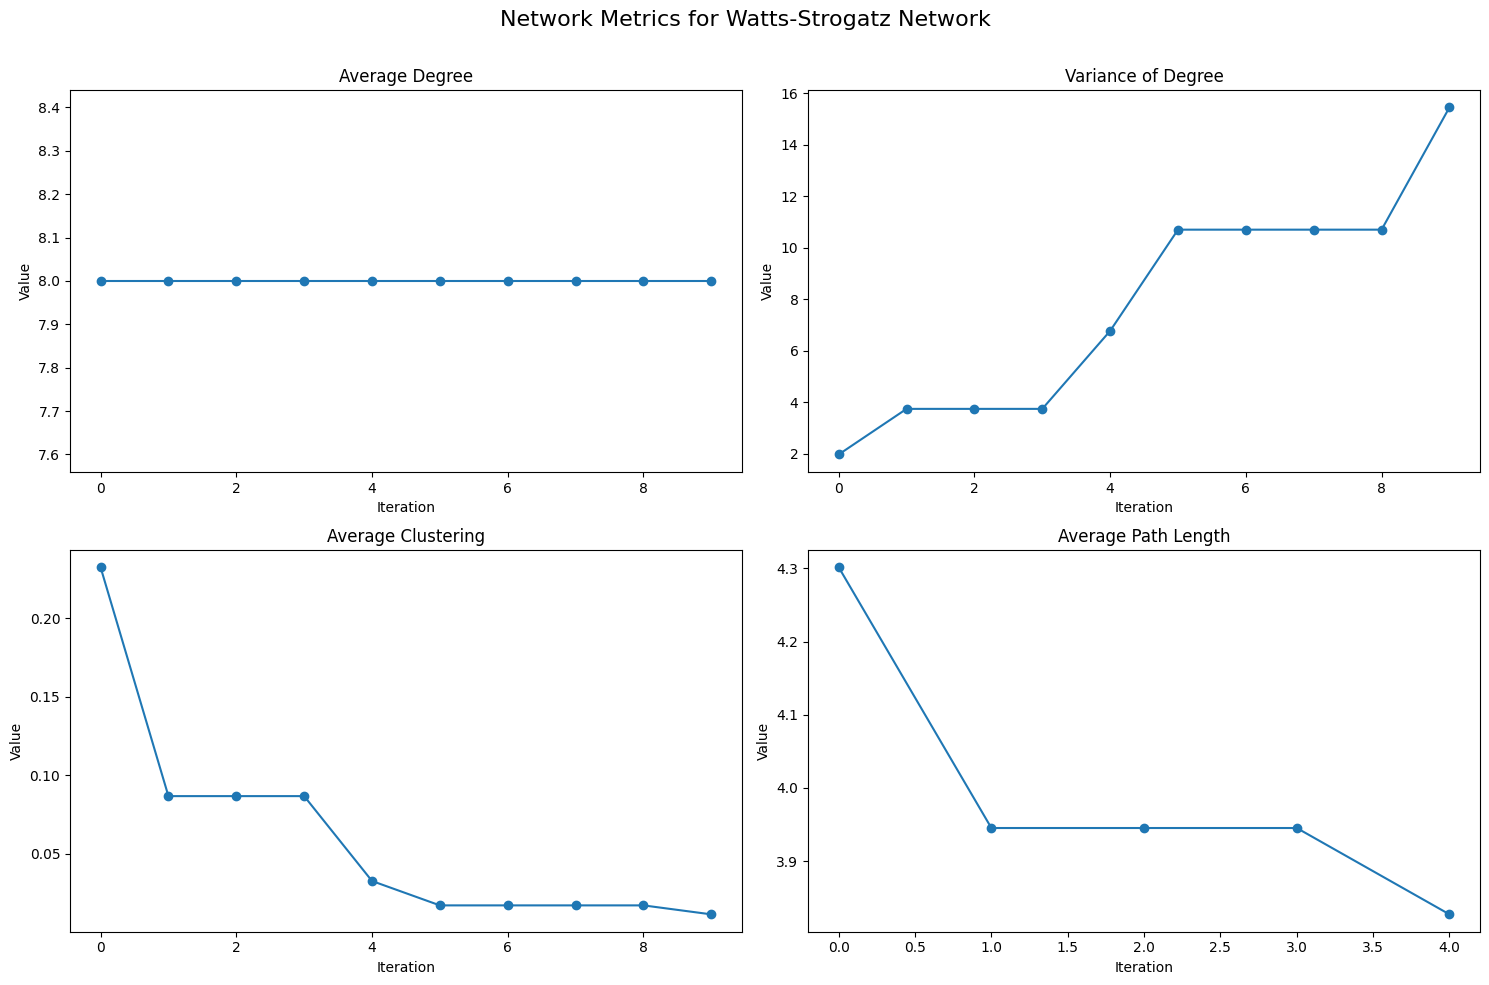

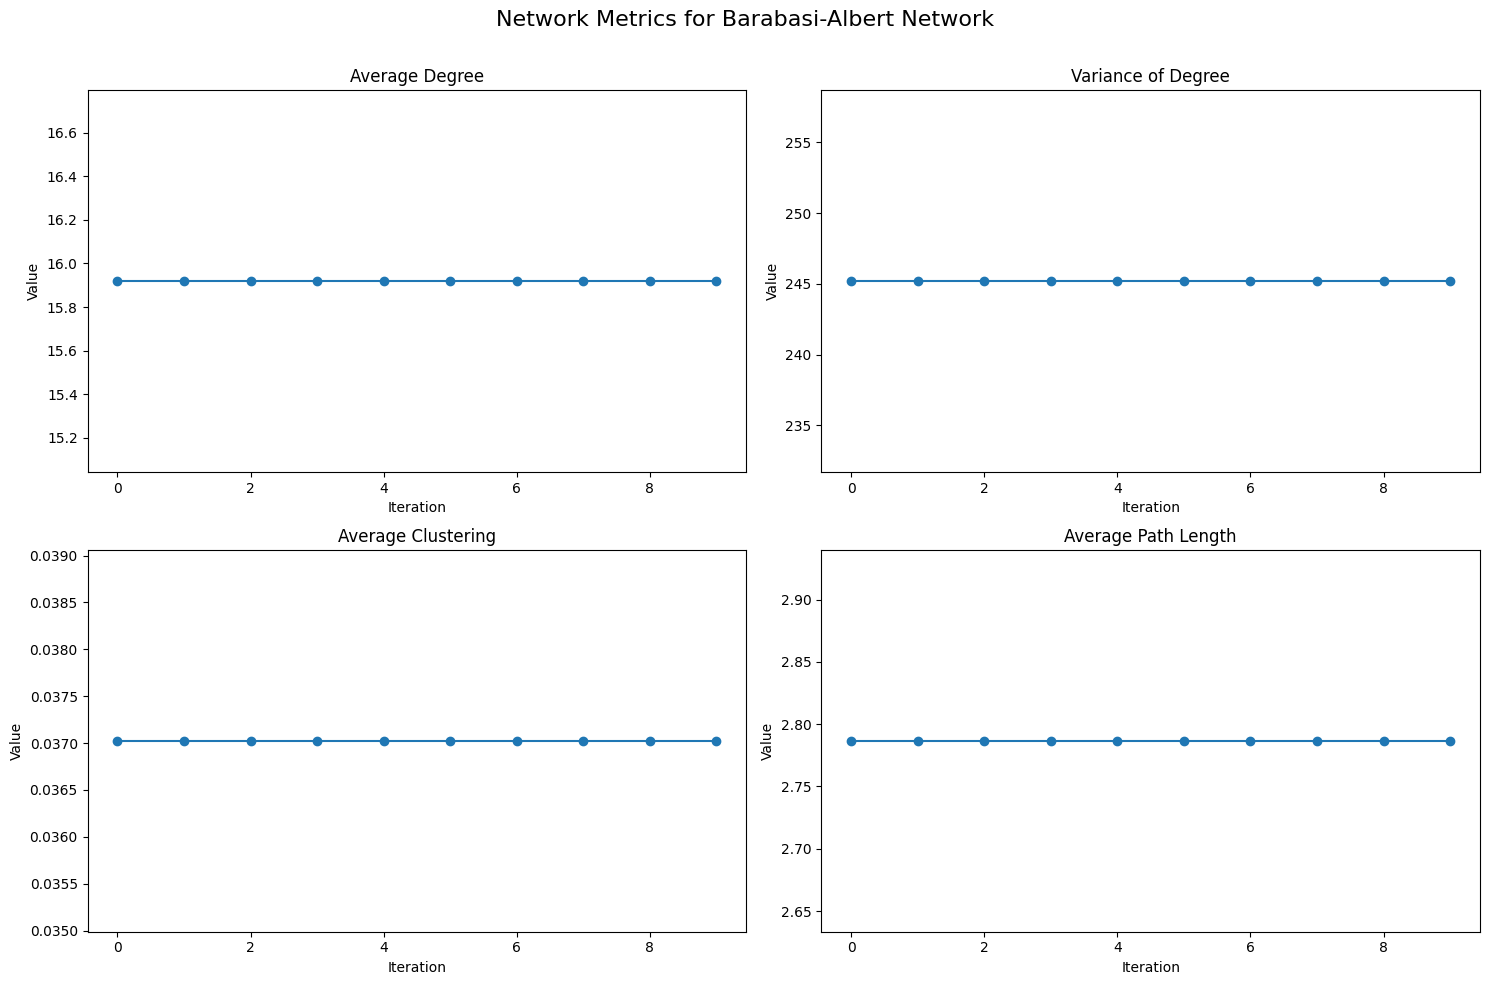

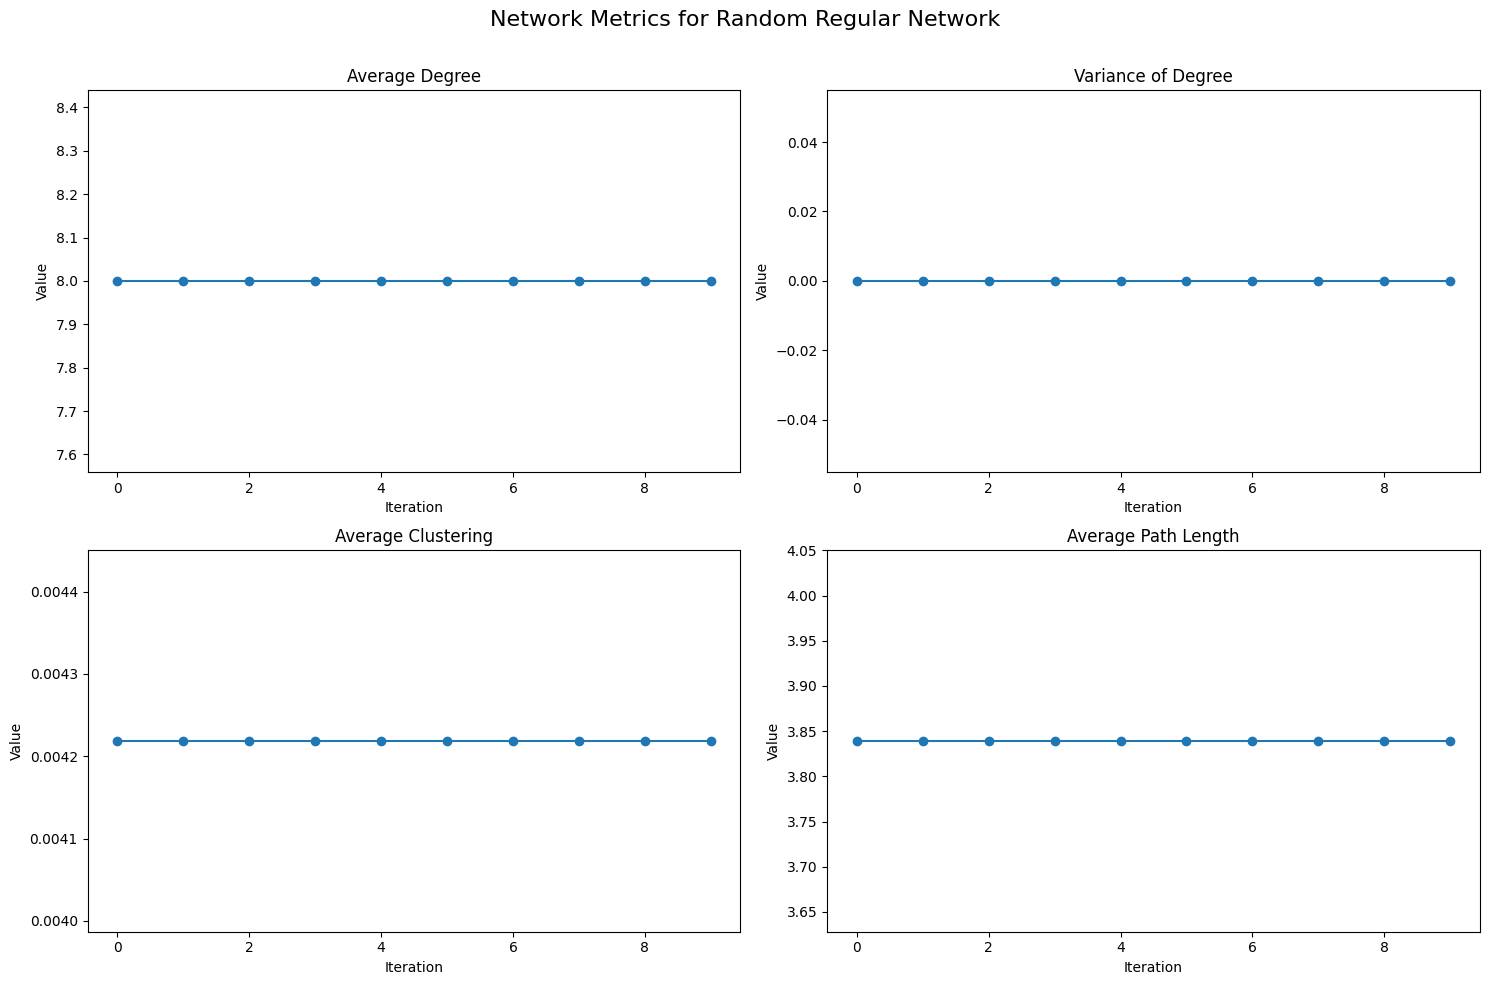

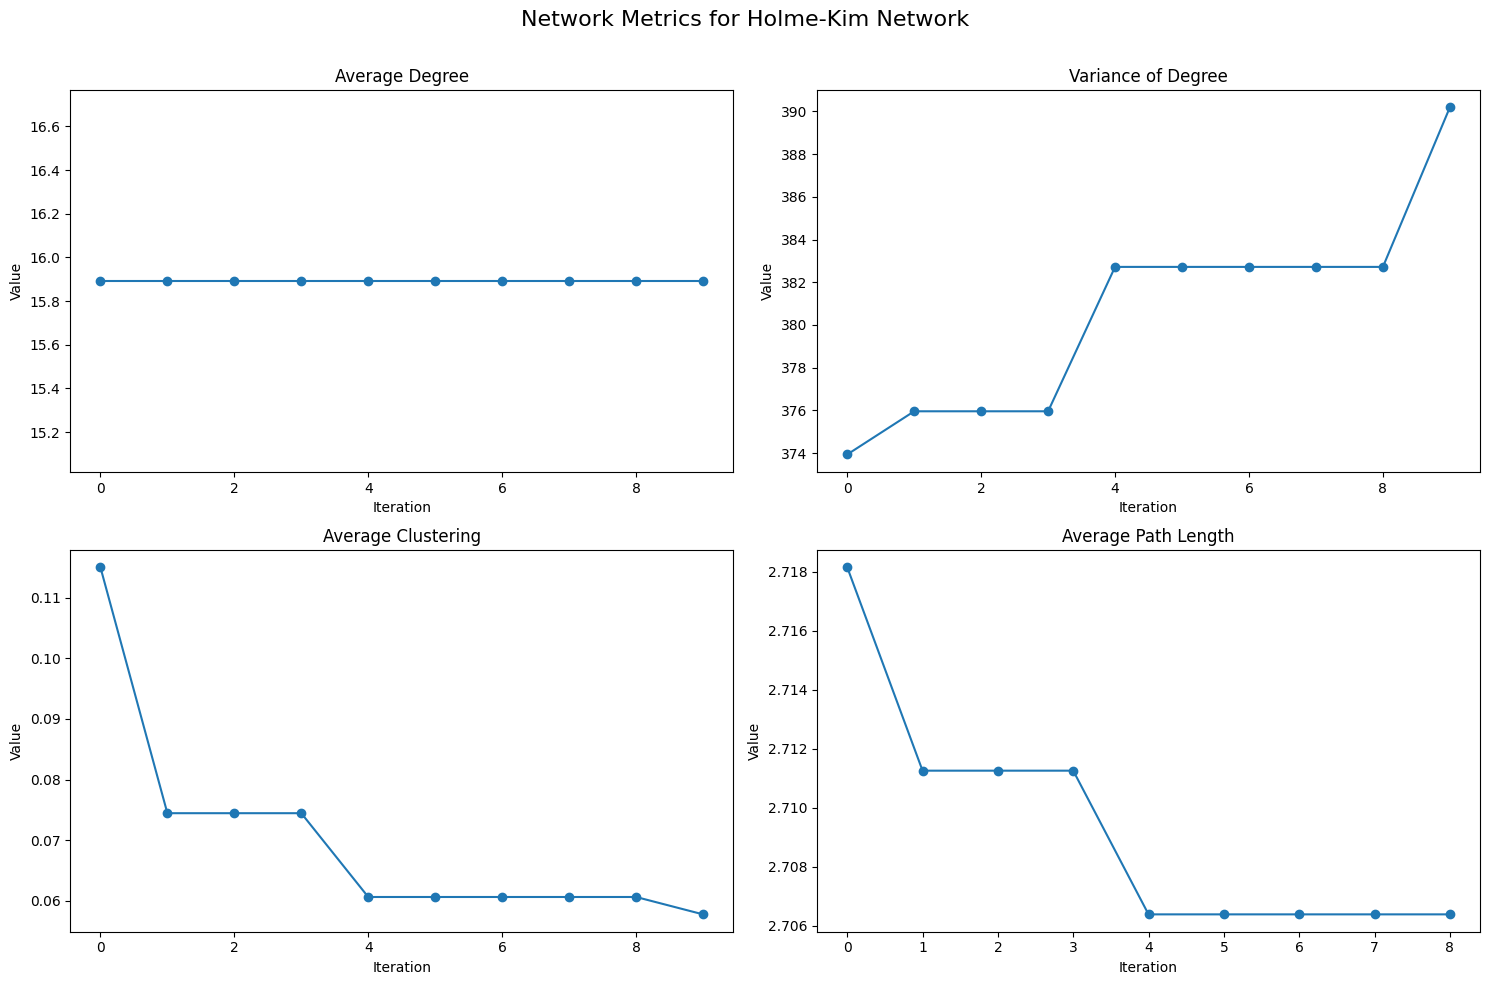

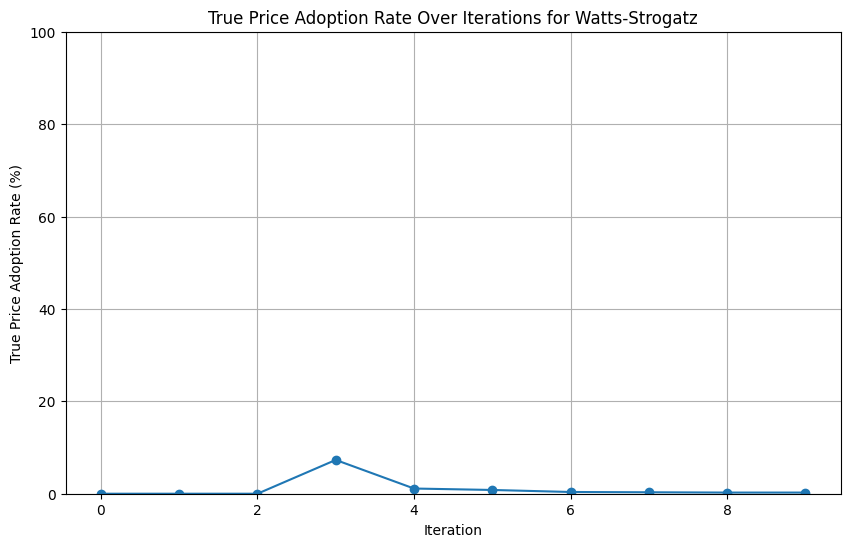

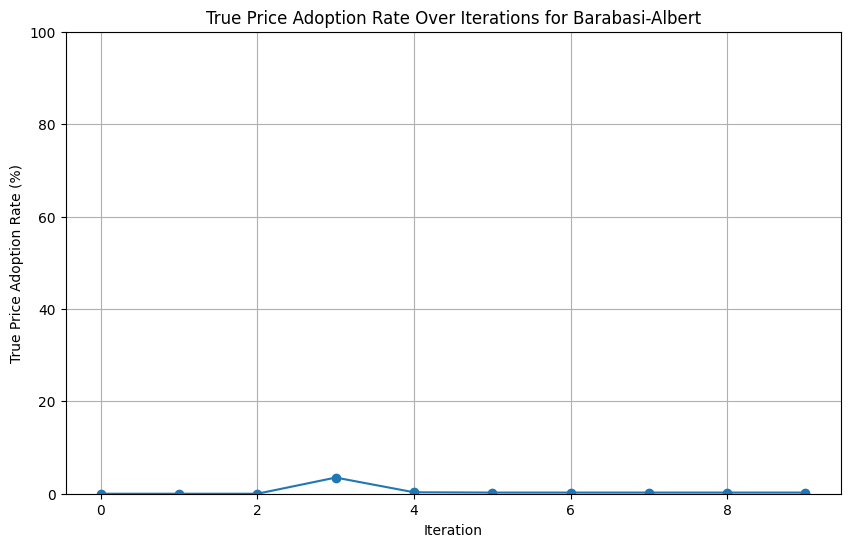

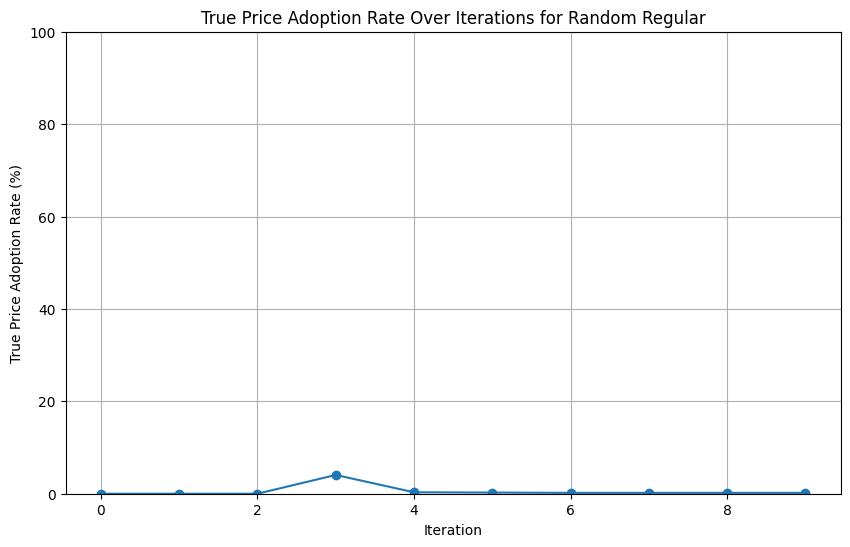

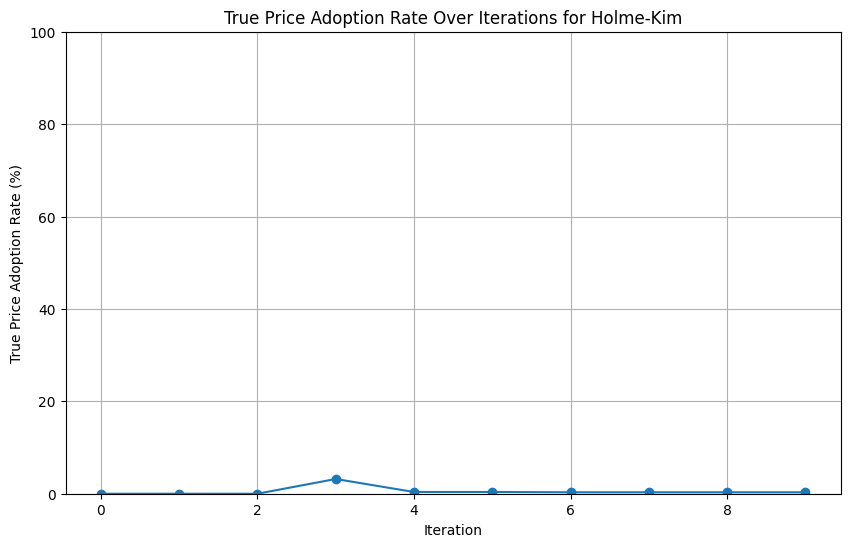

In [133]:
for config_name, network_metrics in results.items():
    plot_network_metrics(network_metrics, config_name)

for config_name, sim_data in simulation_data_results.items():
    plot_adoption_rates(sim_data, config_name)


In [135]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

tp_percentage_values = np.arange(0, 1.00, 0.1)
num_steps = 10
tp_percentages_percent = tp_percentage_values * 100


def run_simulations_for_tp_percentages(tp_percentage_values, base_network_config, num_steps, num_simulations):
    results = {}
    for config_name, base_config in base_network_config.items():
        results[config_name] = {}
        for tp_percentage in tp_percentage_values:
            config = base_config.copy()
            config['TP_percentage'] = tp_percentage
            simulation_data, _ = run_multiple_simulations(config, num_steps, num_simulations)
            results[config_name][tp_percentage] = simulation_data
    return results
    
def plot_adoption_rates_for_different_tp(results):
    for config_name, tp_results in results.items():
        plt.figure(figsize=(12, 8))
        for tp_percentage, simulation_data in tp_results.items():
            avg_adoption_rates = []
            for sim_data in simulation_data:
                avg_adoption_rates.append(sim_data['Adoption Rates'].values)
            avg_adoption_rates = np.mean(avg_adoption_rates, axis=0)
            plt.plot(avg_adoption_rates, label=f'TP_percentage = {tp_percentage}', marker='o')
        plt.title(f'True Price Adoption Rate Over Time for {config_name} Network')
        plt.xlabel('Iteration')
        plt.ylabel('True Price Adoption Rate (%)')
        plt.ylim(0, 100)
        plt.legend()
        plt.grid(True)
        plt.show()

results_tp = run_simulations_for_tp_percentages(tp_percentage_values, network_configurations, num_steps, num_simulations)


Simulation Progress: 100%|██████████| 10/10 [00:39<00:00,  3.95s/it]


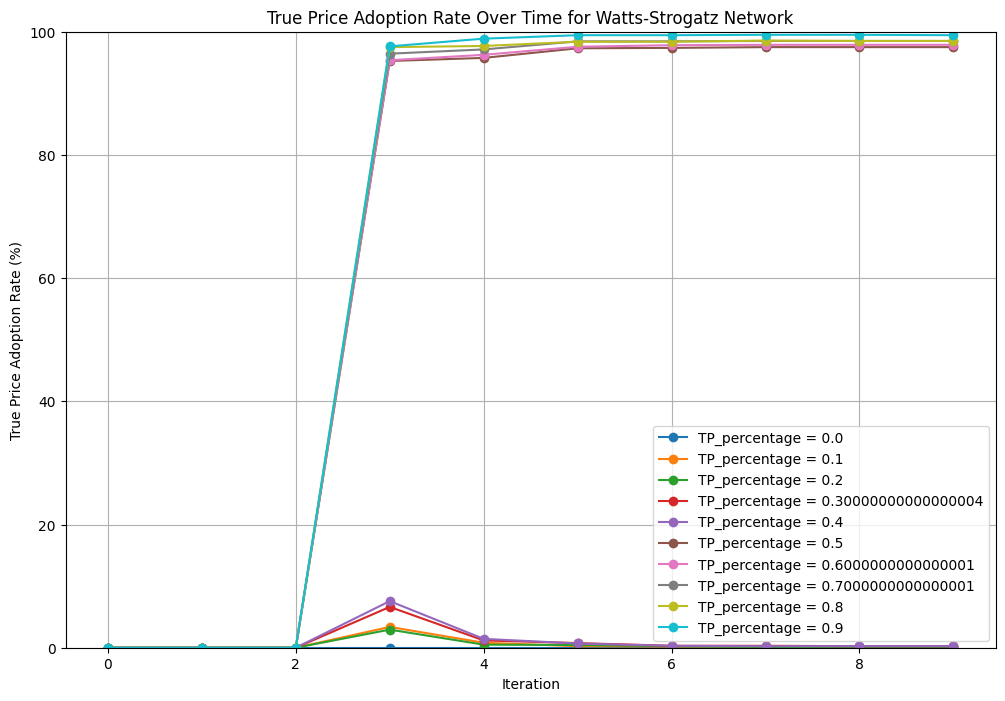

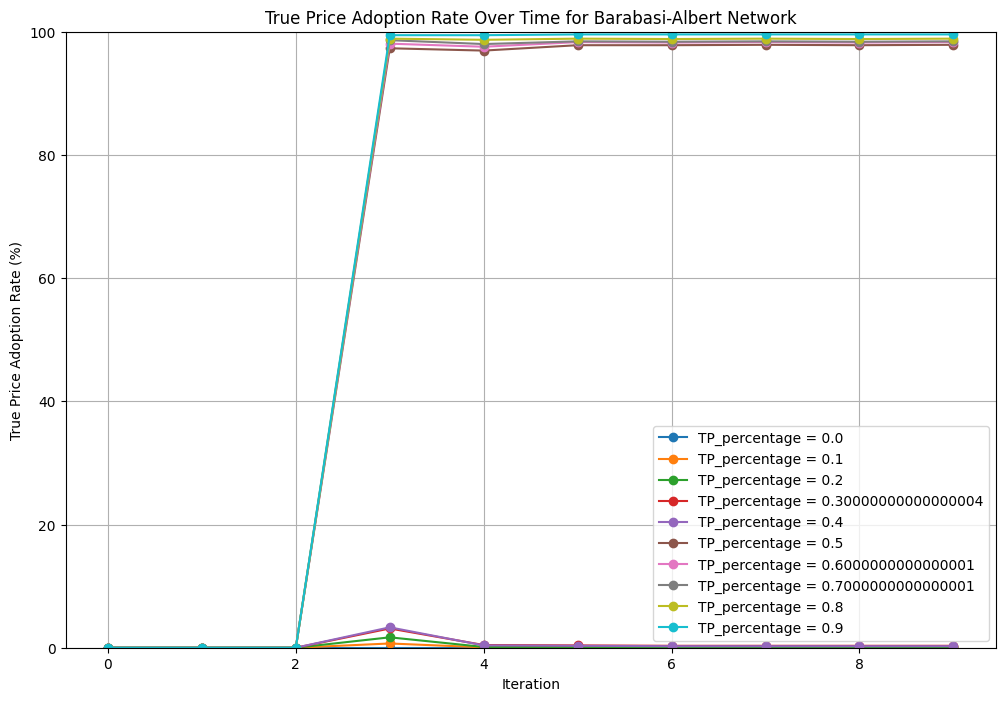

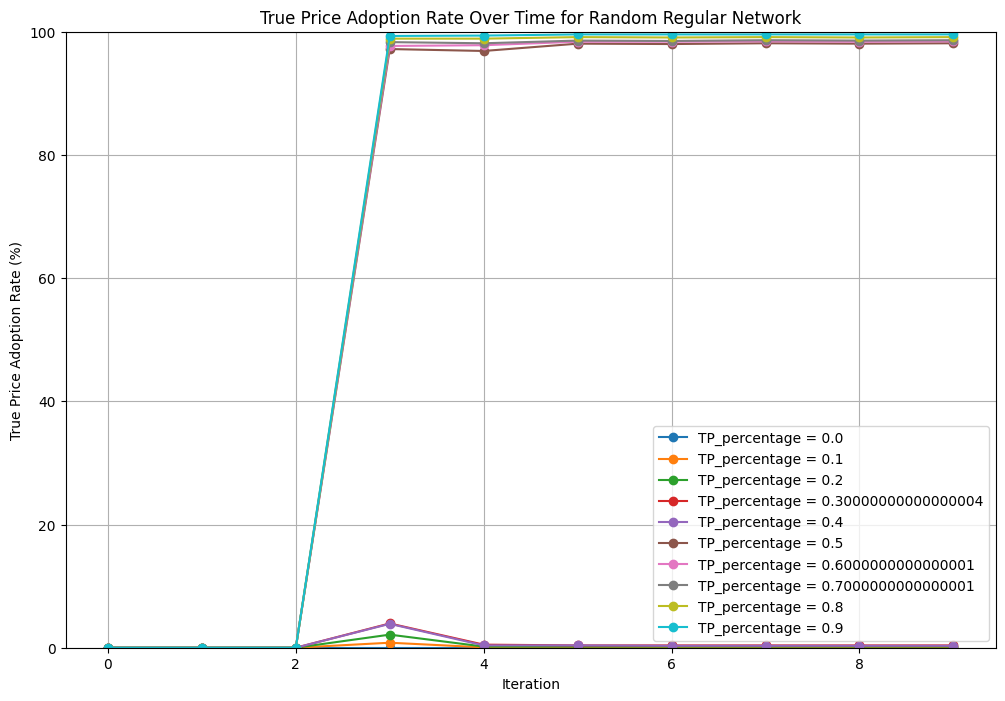

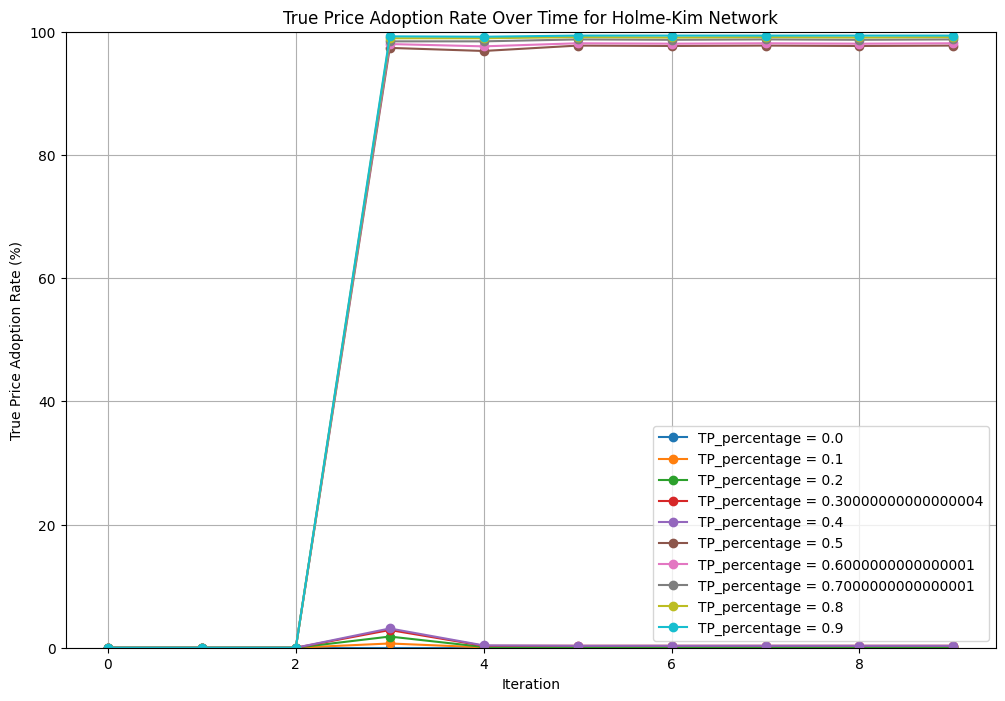

In [137]:
plot_adoption_rates_for_different_tp(results_tp)


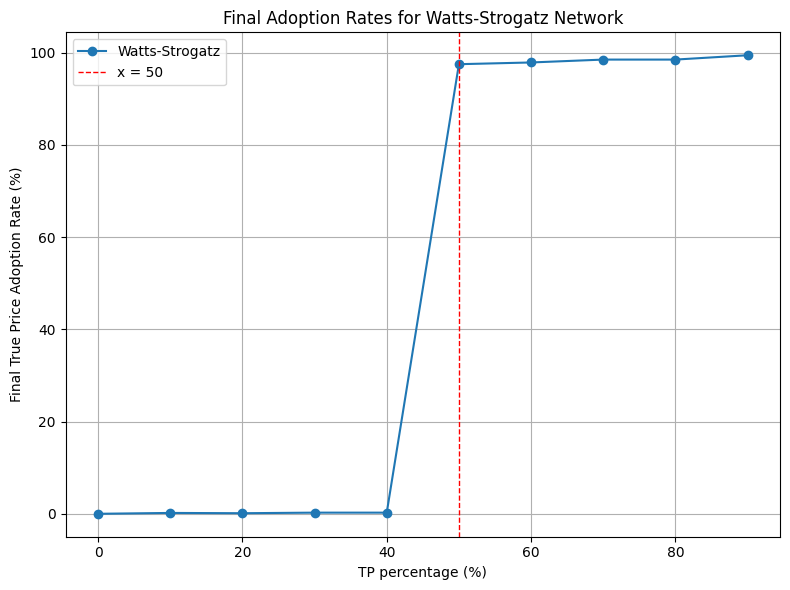

<Figure size 640x480 with 0 Axes>

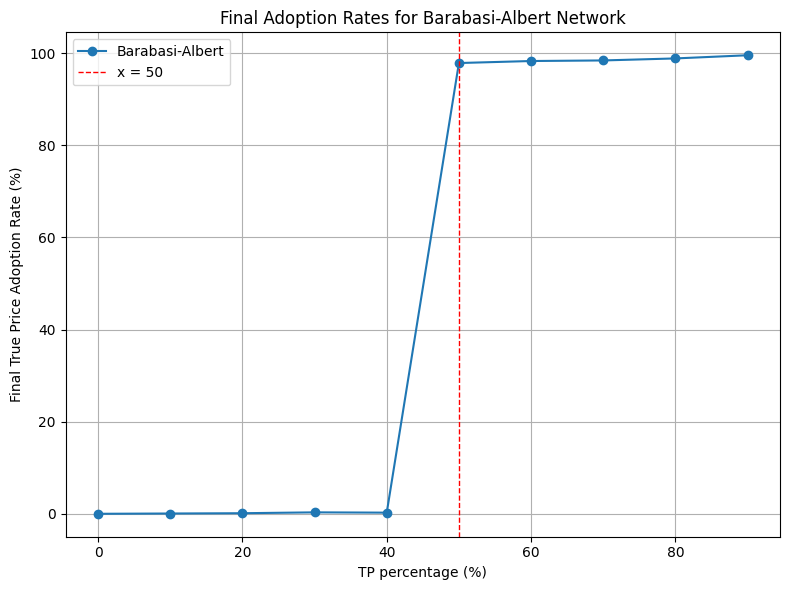

<Figure size 640x480 with 0 Axes>

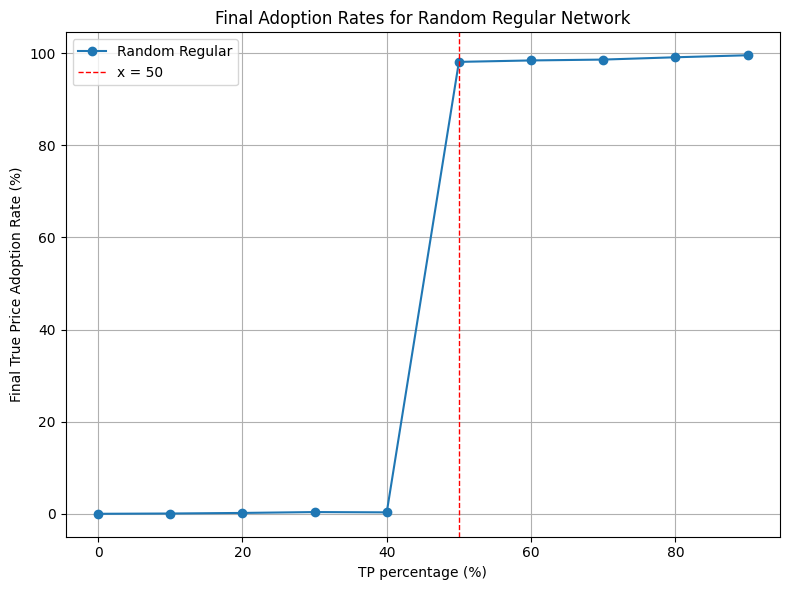

<Figure size 640x480 with 0 Axes>

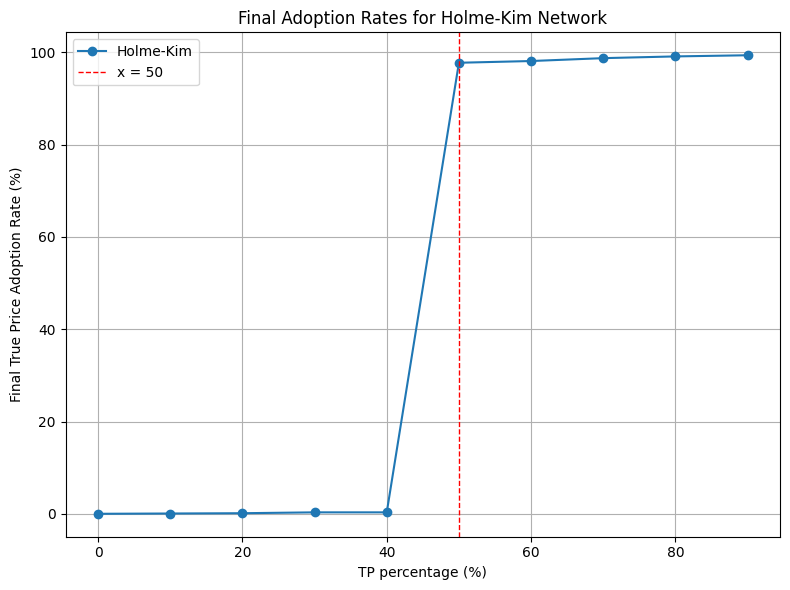

<Figure size 640x480 with 0 Axes>

In [ ]:
tp_percentage_values = np.arange(0, 1.00, 0.1)
num_steps = 10
tp_percentages_percent = tp_percentage_values * 100

def plot_final_adoption_rates_by_tp(results, tp_percentage_values, save_dir='./'):
    tp_percentages_percent = tp_percentage_values * 100
    
    for config_name, tp_results in results.items():
        final_adoption_rates = {tp_percentage: [] for tp_percentage in tp_percentage_values}
        
        for tp_percentage, simulation_data in tp_results.items():
            for sim_data in simulation_data:
                final_adoption_rates[tp_percentage].append(sim_data['Adoption Rates'].values[-1])  # Get final adoption rate
        
        # Prepare data for plotting
        tp_percentages = []
        avg_final_adoption_rates = []
        
        for tp_percentage in tp_percentage_values:
            tp_percentages.append(tp_percentage * 100)
            avg_final_adoption_rates.append(np.mean(final_adoption_rates[tp_percentage]))  # Average over simulations

        # Plotting the final adoption rates
        plt.figure(figsize=(8, 6))
        plt.plot(tp_percentages, avg_final_adoption_rates, marker='o', label=config_name)
        plt.axvline(x=50, color='red', linestyle='--', linewidth=1, label='x = 50')
        plt.xlabel('TP percentage (%)')
        plt.ylabel('Final True Price Adoption Rate (%)')
        plt.grid(True)
        plt.title(f'Final Adoption Rates for {config_name} Network')
        plt.tight_layout()
        plt.legend()
        filename = f"{save_dir}final_adoption_rate_{config_name}.png"
        plt.savefig(filename)
        plt.show()
        plt.clf()
        
plot_final_adoption_rates_by_tp(results_tp, tp_percentage_values)


In [148]:


def collect_simulation_data(model, num_steps):
    collected_data = {
        'Step': [],
        'Adoption Rate': [],
        'Avg_F_Satisfaction': [],
        'Avg_S_Satisfaction': [],
        'Avg_P_Satisfaction': [],
        'Avg_F_Uncertainty': [],
        'Avg_S_Uncertainty': [],
        'Avg_P_Uncertainty': []
    }

    for step in tqdm(range(num_steps), desc='Simulation Progress'):
        model.step()
        collected_data['Step'].append(step)
        collected_data['Adoption Rate'].append(model.calculate_true_price_adoption_rate())
        collected_data['Avg_F_Satisfaction'].append(np.mean([agent.F_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_S_Satisfaction'].append(np.mean([agent.S_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_P_Satisfaction'].append(np.mean([agent.P_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_F_Uncertainty'].append(np.mean([agent.F_uncertainty for agent in model.schedule.agents]))
        collected_data['Avg_S_Uncertainty'].append(np.mean([agent.S_uncertainty for agent in model.schedule.agents]))
        collected_data['Avg_P_Uncertainty'].append(np.mean([agent.P_uncertainty for agent in model.schedule.agents]))

    model_data = pd.DataFrame(collected_data)
    return model_data

def plot_metric(all_results, metric, ylabel, filename, scale_as_percentage=False):
    plt.figure(figsize=(15, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, len(all_results)))

    for tp, color in zip(all_results.keys(), colors):
        data = all_results[tp]
        if scale_as_percentage:
            plt.plot(data['Step'], data[metric] * 100, label=f'TP_percentage={tp * 100:.0f}%', color=color)
        else:
            plt.plot(data['Step'], data[metric], label=f'TP_percentage={tp * 100:.0f}%', color=color)

    plt.xlabel('Step', fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.legend(title='TP_percentage')
    plt.grid(True)

    if scale_as_percentage:
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

    plt.savefig(filename)
    plt.close()

def run_simulations_for_tp_percentages_and_networks(tp_percentage_values, base_network_config, num_steps, num_simulations):
    results = {}
    for config_name, base_config in base_network_config.items():
        results[config_name] = {}
        for tp_percentage in tp_percentage_values:
            config = base_config.copy()
            config['TP_percentage'] = tp_percentage
            model = ConsumatModel(config)
            model_data = collect_simulation_data(model, num_steps)
            results[config_name][tp_percentage] = model_data
    return results

network_configurations = {
    'Watts-Strogatz': watts_strogatz_config,
    'Barabasi-Albert': barabasi_albert_config,
    'Random Regular': random_regular_config,
    'Holme-Kim': holme_kim_config
}

tp_percentages = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
num_steps = 10
num_simulations = 1

results = run_simulations_for_tp_percentages_and_networks(tp_percentages, network_configurations, num_steps, num_simulations)

for config_name, all_results in results.items():
    plot_metric(all_results, 'Avg_F_Satisfaction', 'Average Financial Satisfaction', f'avg_financial_satisfaction_{config_name}.png')
    plot_metric(all_results, 'Avg_S_Satisfaction', 'Average Social Satisfaction', f'avg_social_satisfaction_{config_name}.png')
    plot_metric(all_results, 'Avg_P_Satisfaction', 'Average Personal Satisfaction', f'avg_personal_satisfaction_{config_name}.png')
    plot_metric(all_results, 'Avg_F_Uncertainty', 'Average Financial Uncertainty', f'avg_financial_uncertainty_{config_name}.png')
    plot_metric(all_results, 'Avg_S_Uncertainty', 'Average Social Uncertainty', f'avg_social_uncertainty_{config_name}.png')
    plot_metric(all_results, 'Avg_P_Uncertainty', 'Average Personal Uncertainty', f'avg_personal_uncertainty_{config_name}.png')


Simulation Progress: 100%|██████████| 10/10 [00:23<00:00,  2.31s/it]


## Network topology

### Watts-Strogatz Network
- **Type:** Small-world network
- **Known For:** High clustering coefficient and short average path lengths, which mimic many real-world social networks.
- **Formation:** Starts with a ring of `n` nodes each connected to `k` nearest neighbors. Rewires each edge with probability `p` to a randomly chosen node.
- **Key Parameters:**
  - `n`: Number of nodes
  - `k`: Number of nearest neighbors in the initial ring topology
  - `p`: Probability of rewiring each edge

### Barabasi-Albert Network
- **Type:** Scale-free network
- **Known For:** Its degree distribution follows a power law, which is typical for many large networks such as the internet, citation networks, and some social networks.
- **Formation:** Begins with a small number of nodes and adds new nodes one at a time. Each new node is connected to `m` existing nodes with a probability that depends on the number of links that the existing nodes already have.
- **Key Parameters:**
  - `n`: Total number of nodes
  - `m`: Number of edges to attach from a new node to existing nodes

### Random Regular Network
- **Type:** Regular graph
- **Known For:** Every node has the same number of connections. This uniformity can represent idealized conditions in network modeling.
- **Formation:** Constructed by connecting each node with `d` neighbors chosen at random, ensuring each has the same degree, while avoiding self-loops and duplicate edges.
- **Key Parameters:**
  - `n`: Total number of nodes
  - `d`: Degree of each node

### Holme-Kim Network
- **Type:** Small-world network with scale-free properties
- **Known For:** Combines high clustering and short path lengths (like Watts-Strogatz) with a degree distribution that follows a power law (like Barabasi-Albert).
- **Formation:** Starts like the Barabasi-Albert model by adding one node at a time, connecting to `m` existing nodes based on their degree. After each edge creation, with probability `p` adds an additional edge forming a triangle.
- **Key Parameters:**
  - `n`: Total number of nodes
  - `m`: Number of edges each new node will attempt to make
  - `p`: Triad formation probability



## Vary network parameters

In [172]:


def create_network_configs(base_config, param_values):
    configs = []
    for network_type, params in param_values.items():
        for param in params:
            config = base_config.copy()
            config.update({
                'network_type': network_type,
                'network_params': param
            })
            configs.append((network_type, param, config))
    return configs



def run_simulations_for_network_params(network_configs, num_steps, num_simulations):
    results = {}
    for network_type, param, config in network_configs:
        param_str = str(param)
        simulation_data = run_multiple_simulations(config, num_steps, num_simulations)
        if network_type not in results:
            results[network_type] = {}
        results[network_type][param_str] = simulation_data
    return results

def run_simulation(model, num_steps):
    adoption_rates = []
    network_metrics = {
        'Average Degree': [],
        'Variance of Degree': [],
        'Average Clustering': [],
        'Average Path Length': []
    }

    for _ in tqdm(range(num_steps), desc='Simulation Progress'):
        model.step()
        current_adoption_rate = model.calculate_true_price_adoption_rate()
        adoption_rates.append(current_adoption_rate)

        degrees = [deg for n, deg in model.G.degree()]
        avg_degree = np.mean(degrees)
        var_degree = np.var(degrees)
        network_metrics['Average Degree'].append(avg_degree)
        network_metrics['Variance of Degree'].append(var_degree)
        network_metrics['Average Clustering'].append(nx.average_clustering(model.G))
        network_metrics['Average Path Length'].append(nx.average_shortest_path_length(model.G) if nx.is_connected(model.G) else None)

    model_data = model.datacollector.get_model_vars_dataframe()
    agent_data = model.datacollector.get_agent_vars_dataframe()
    model_data['Adoption Rates'] = adoption_rates

    return model_data, agent_data, network_metrics

def run_multiple_simulations(config, num_steps, num_simulations):
    all_simulation_data = []

    for _ in range(num_simulations):
        model = ConsumatModel(config)
        model_data, agent_data, network_metrics = run_simulation(model, num_steps)
        all_simulation_data.append((model_data, agent_data, network_metrics))

    return all_simulation_data






In [173]:
def plot_network_metrics_for_network_params(results, network_type, save_dir='./'):
    metrics = ['Average Degree', 'Variance of Degree', 'Average Clustering', 'Average Path Length']
    for metric in metrics:
        plt.figure(figsize=(12, 8))
        for param_str, simulation_data in results.items():
            steps = range(len(simulation_data[0][2][metric]))
            for _, _, metric_data in simulation_data:
                plt.plot(steps, metric_data[metric], label=f'Params = {param_str}', marker='o')
        plt.xlabel('Iteration', fontsize=14)
        plt.ylabel(metric, fontsize=14)
        plt.legend(fontsize = 14)
        plt.grid(True)
        filename = f"{save_dir}{network_type}_{metric.replace(' ', '_').lower()}_new.png"
        #plt.savefig(filename)
        #plt.close()
        plt.show()

def plot_adoption_rates_for_network_params(results, network_type, save_dir='./'):
    plt.figure(figsize=(12, 8))
    for param_str, simulation_data in results.items():
        for model_data, _, _ in simulation_data:
            plt.plot(model_data['Adoption Rates'], label=f'Params = {param_str}', marker = "o")
    plt.xlabel('Iteration', fontsize=14)
    plt.ylabel('True Price Adoption Rate (%)', fontsize=14)
    plt.ylim(0, 100)
    plt.legend(fontsize = 14)
    plt.grid(True)
    filename = f"{save_dir}{network_type}_adoption_rates_new.png"
    #plt.savefig(filename)
    #plt.close()
    plt.show()
# Plot results for Watts-Strogatz

Simulation Progress: 100%|██████████| 10/10 [01:36<00:00,  9.67s/it]


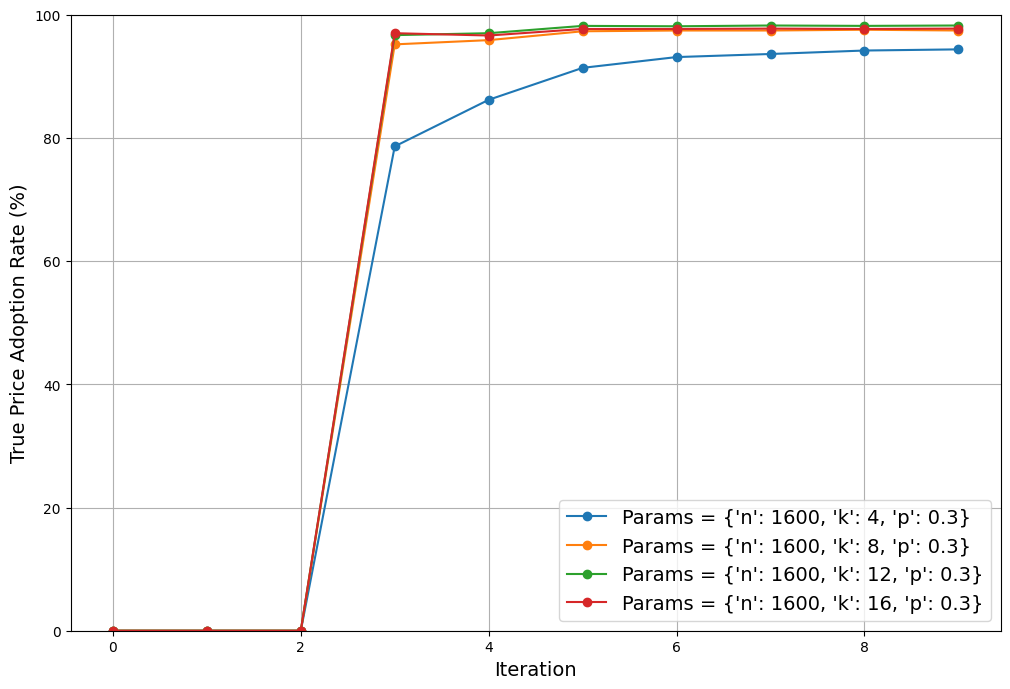

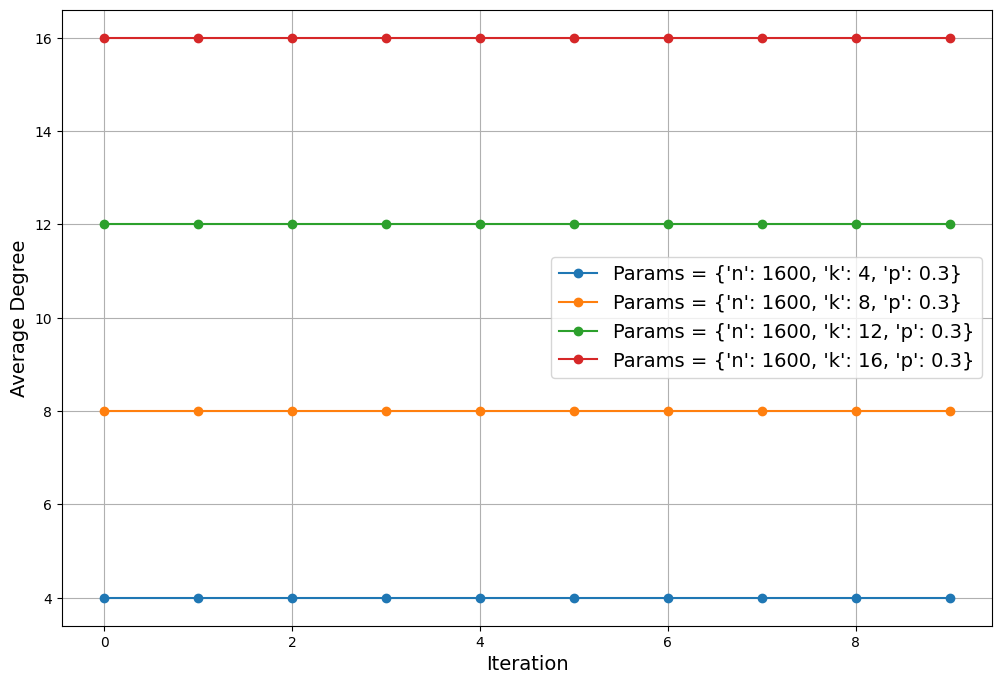

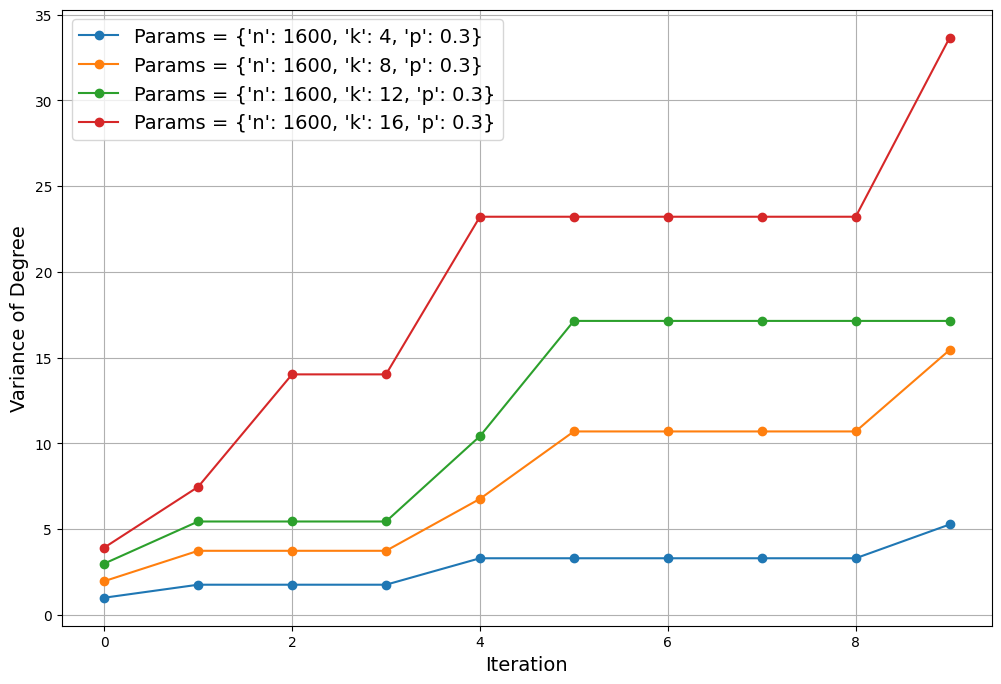

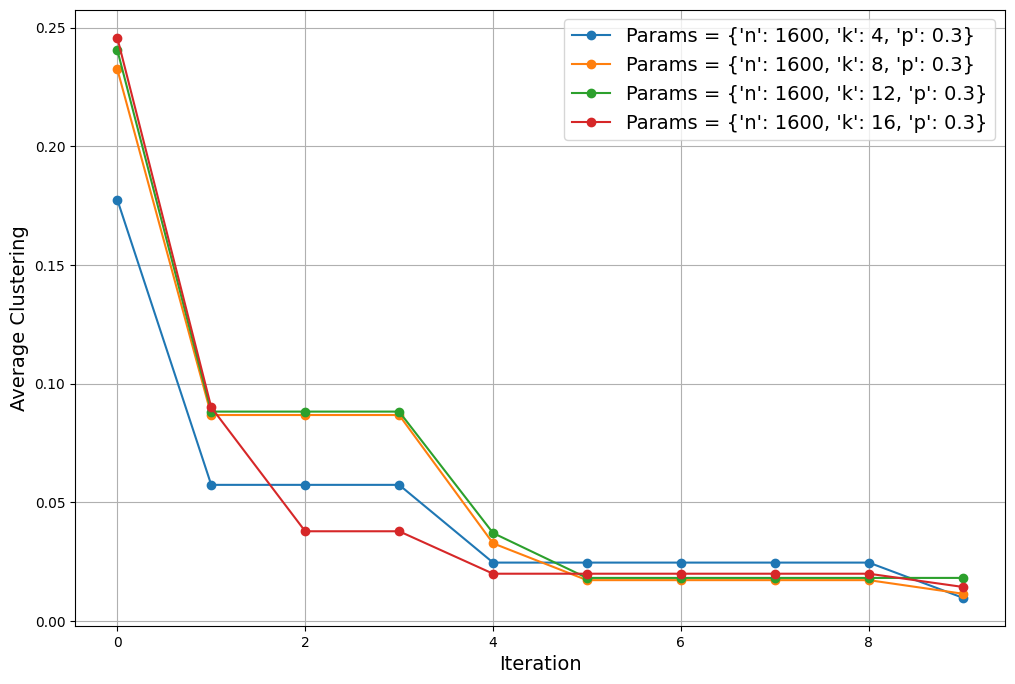

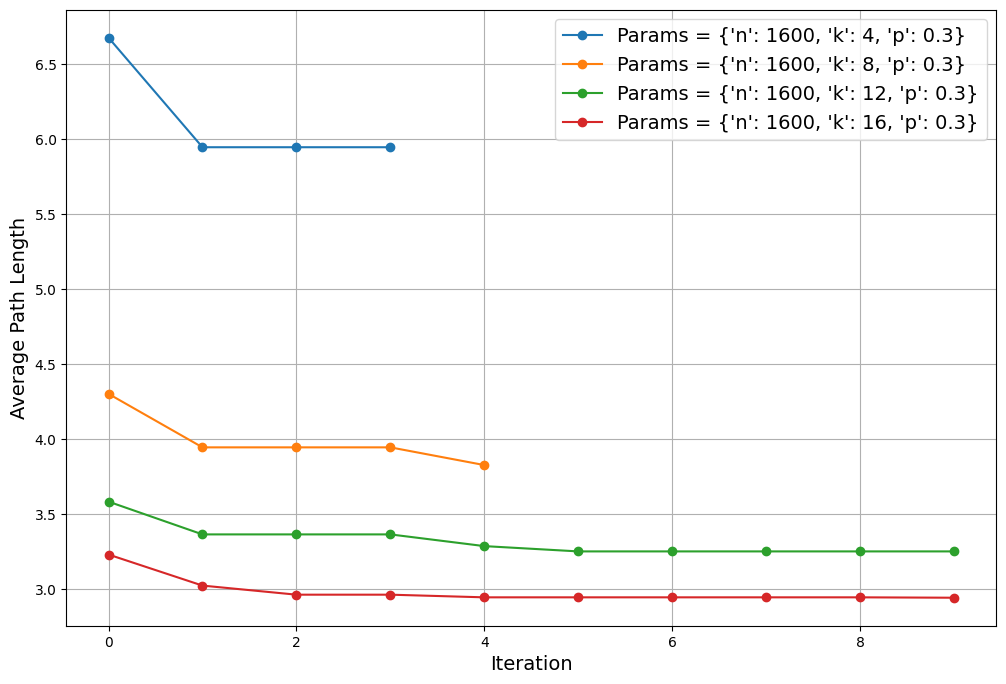

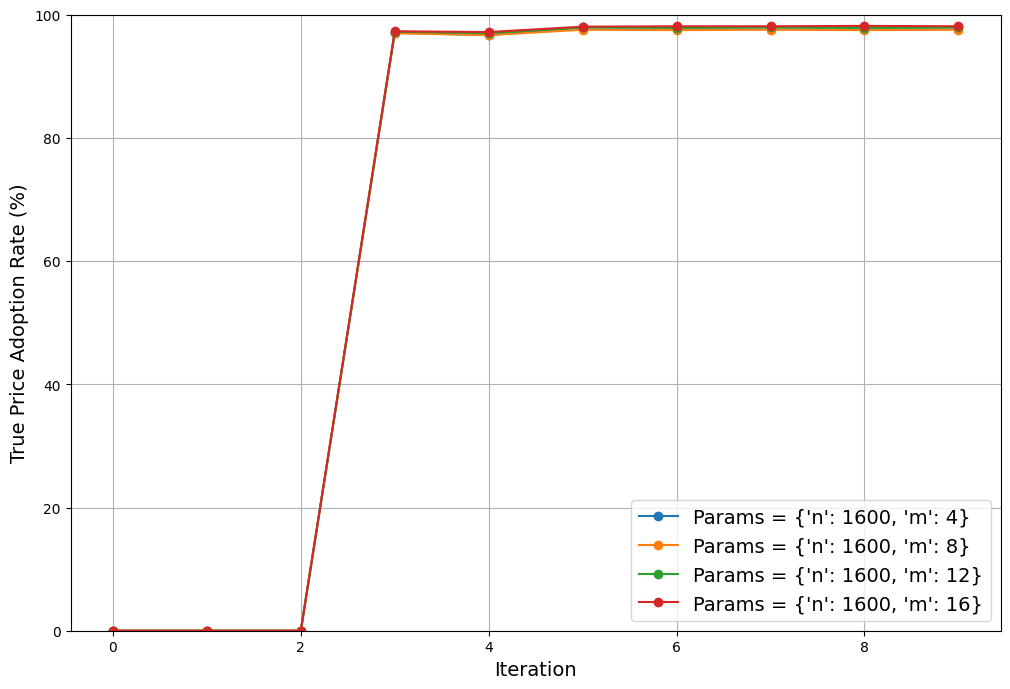

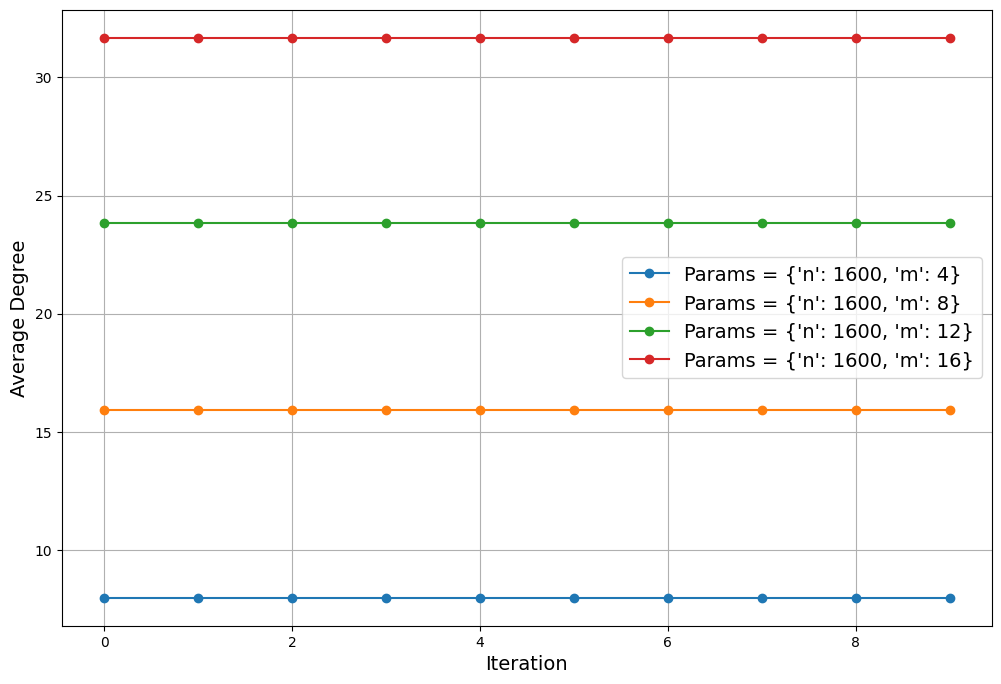

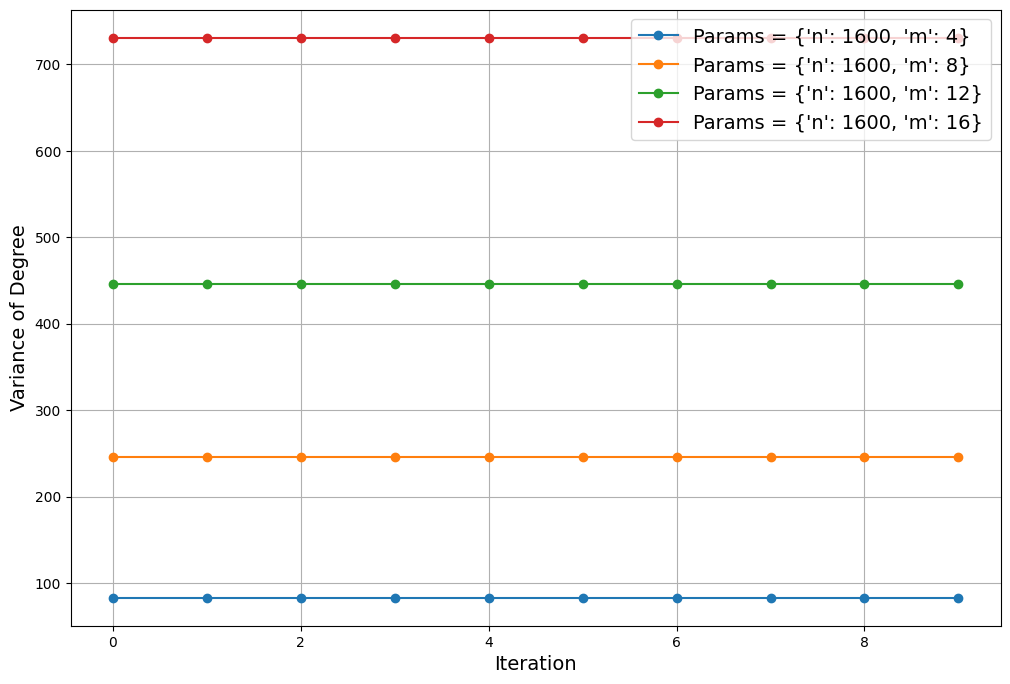

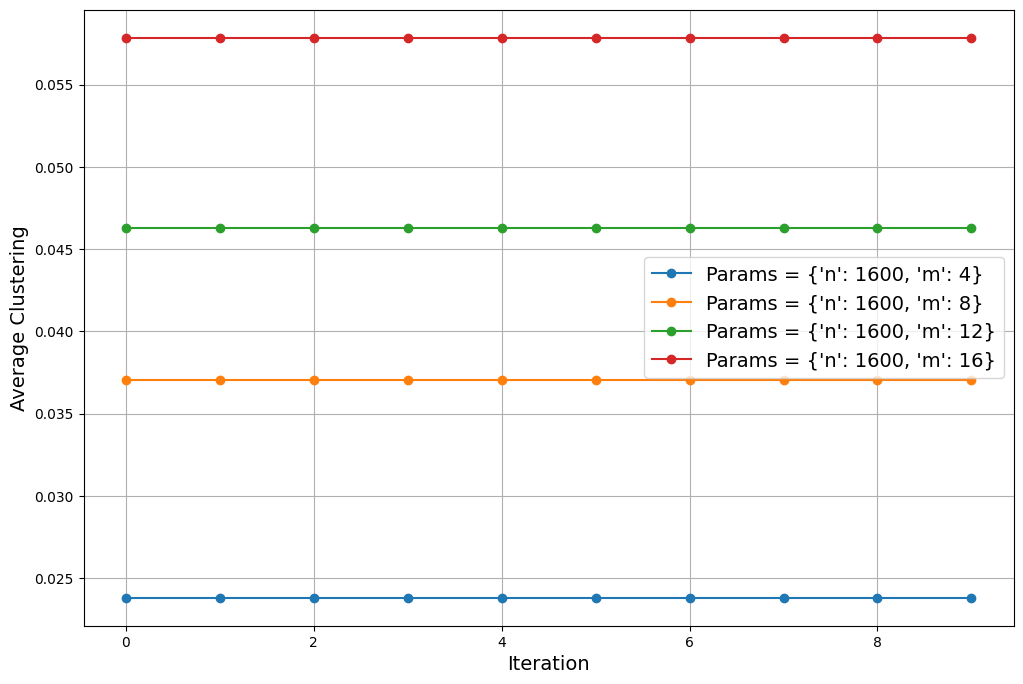

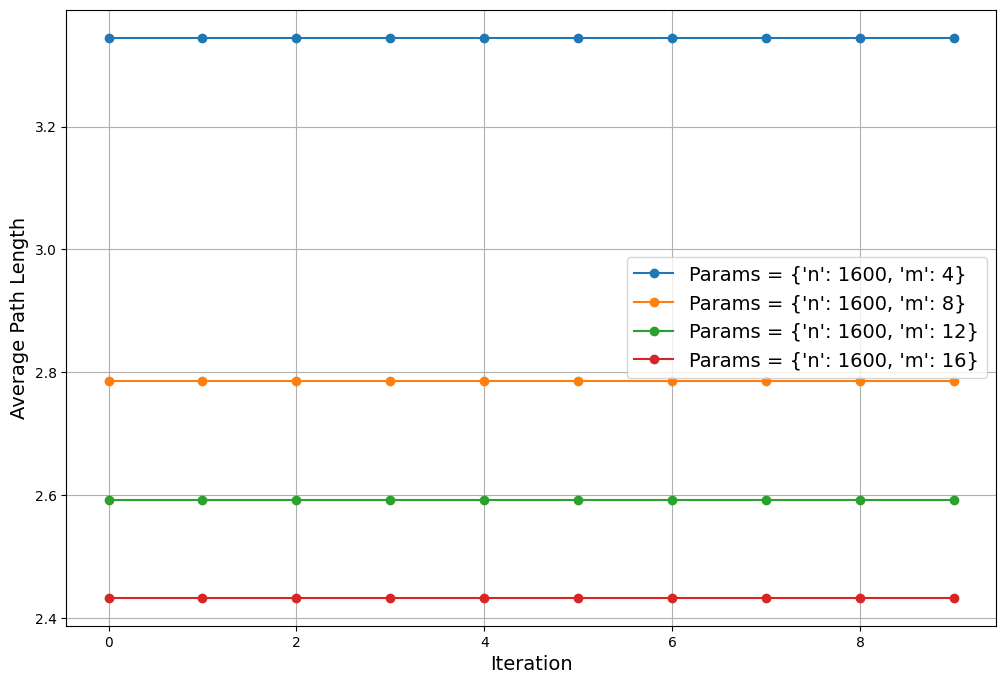

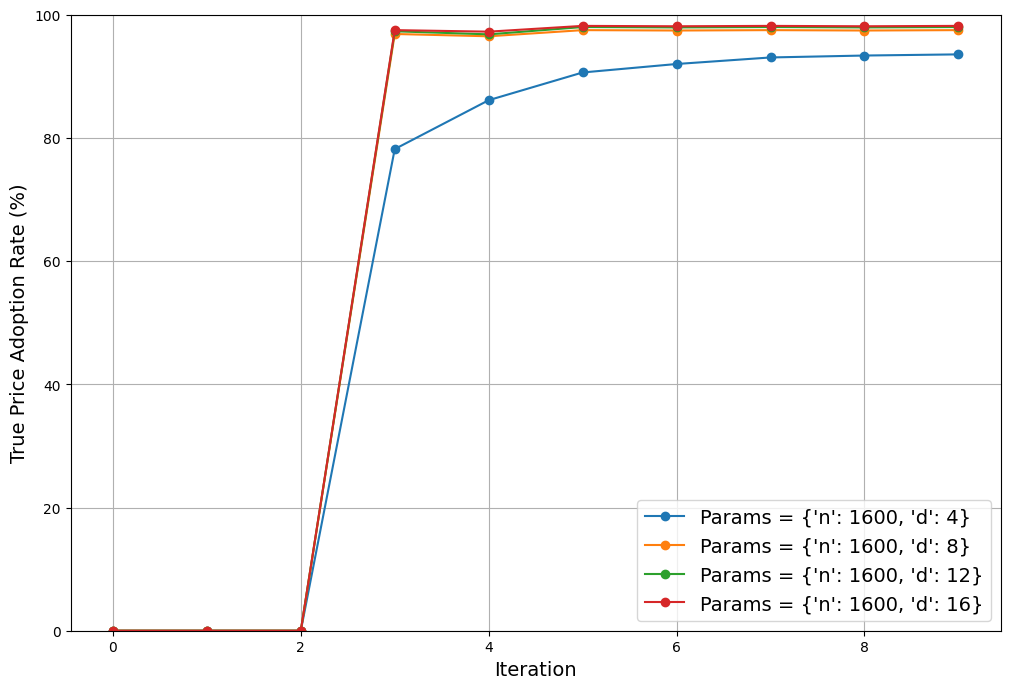

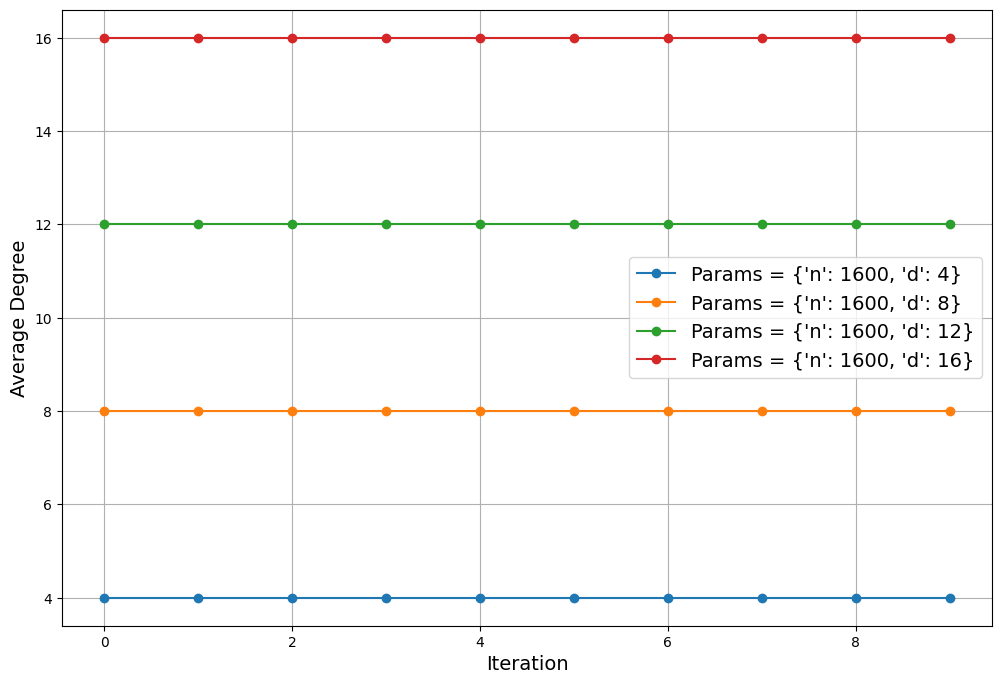

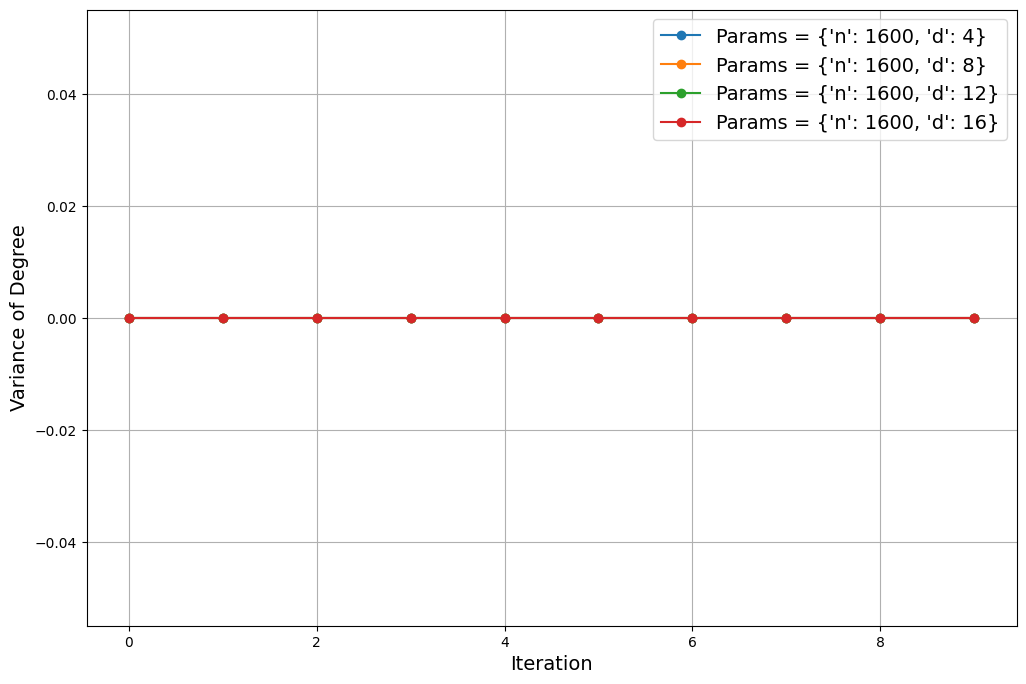

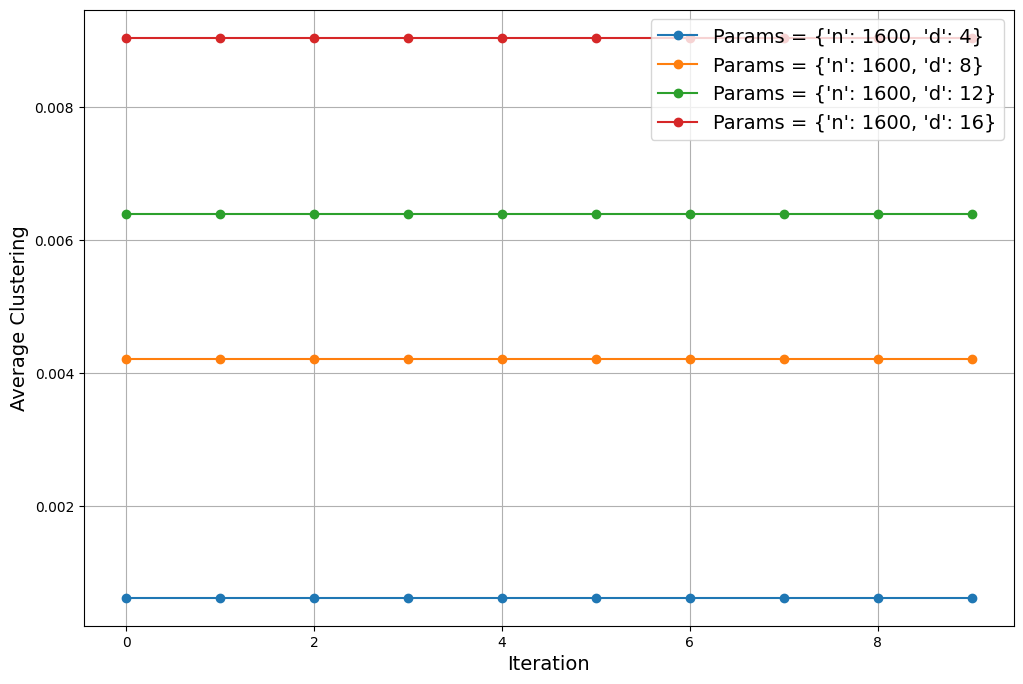

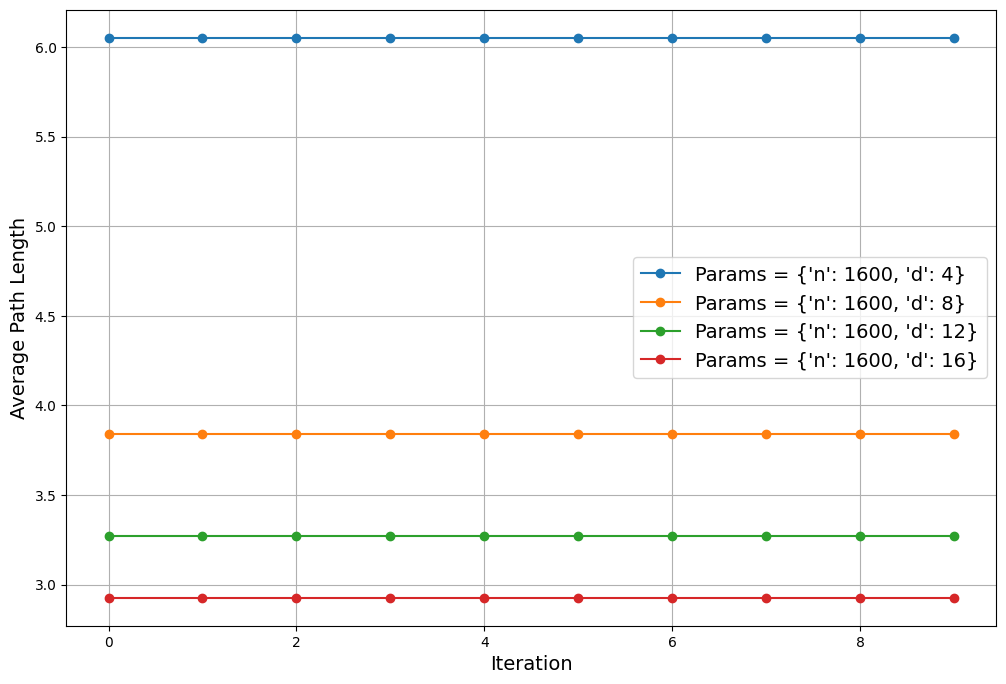

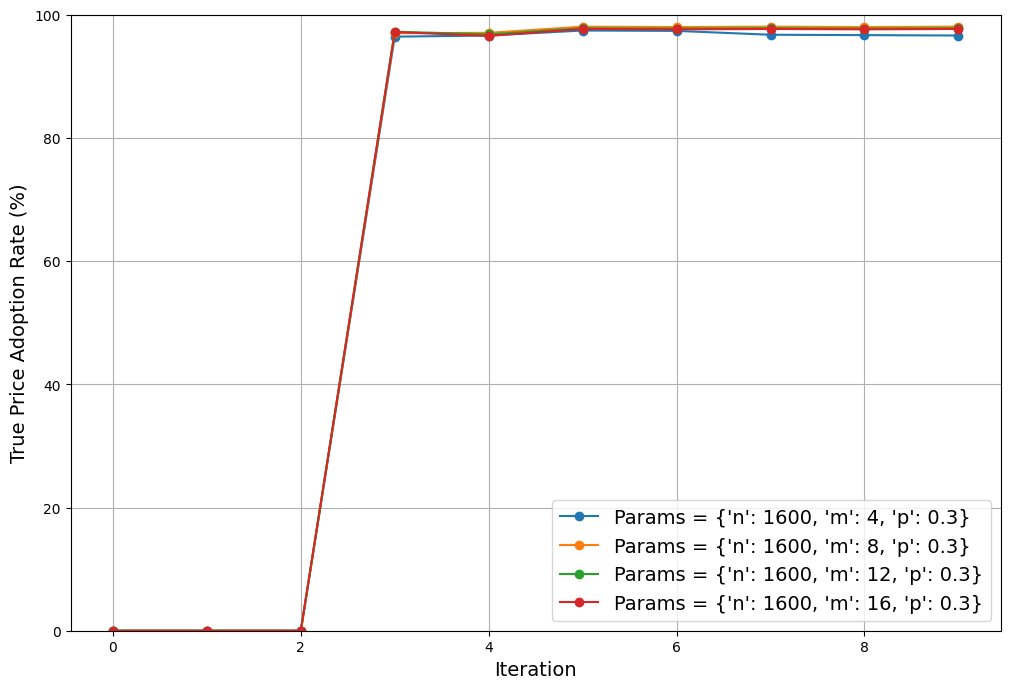

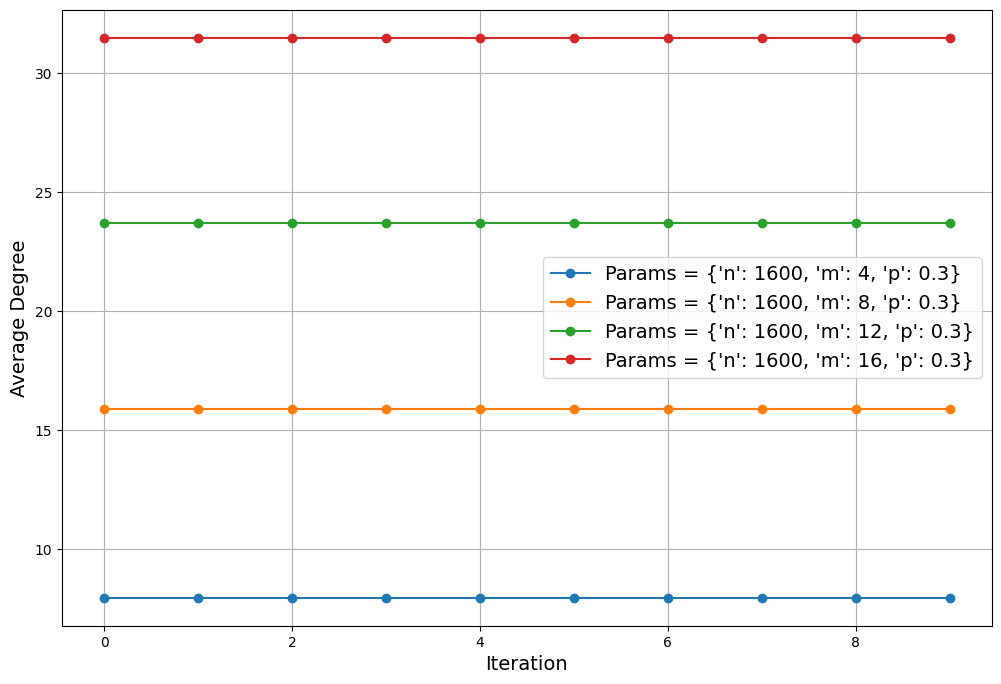

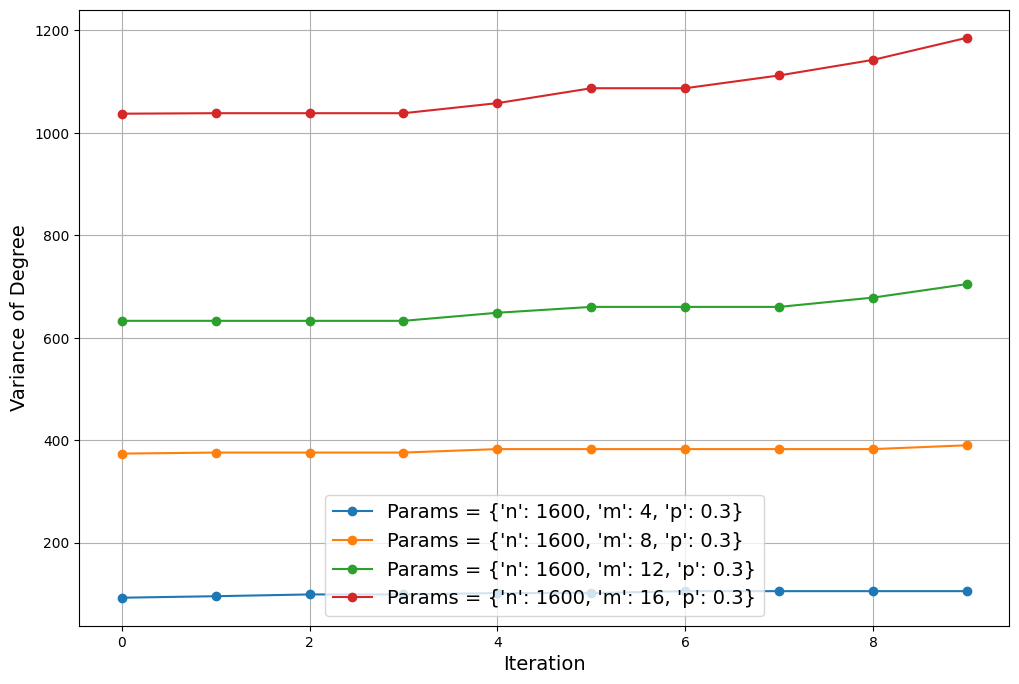

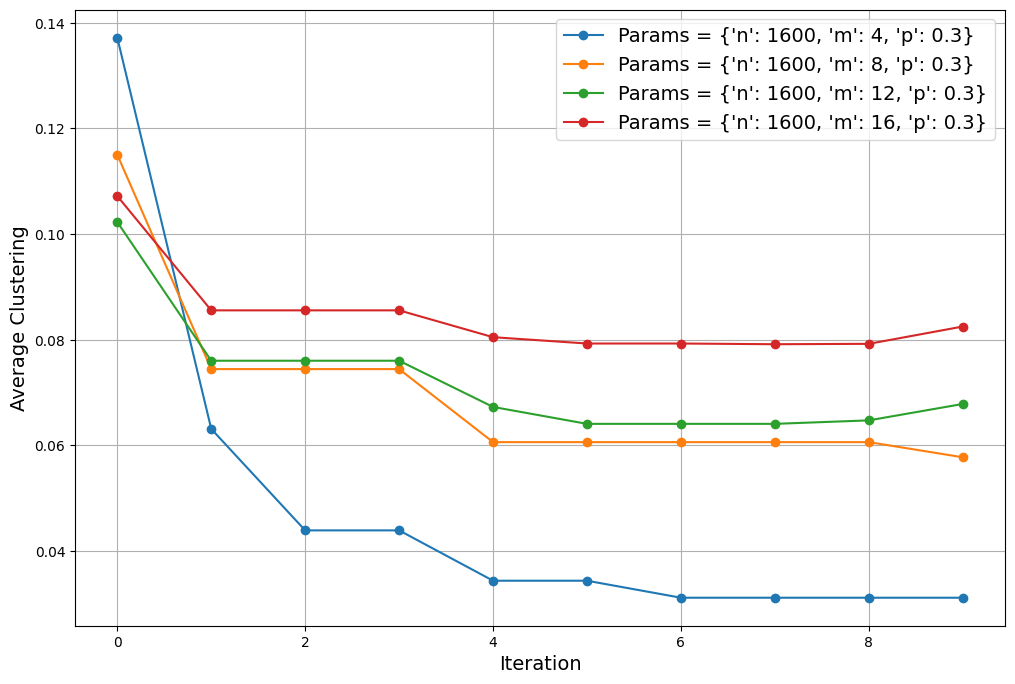

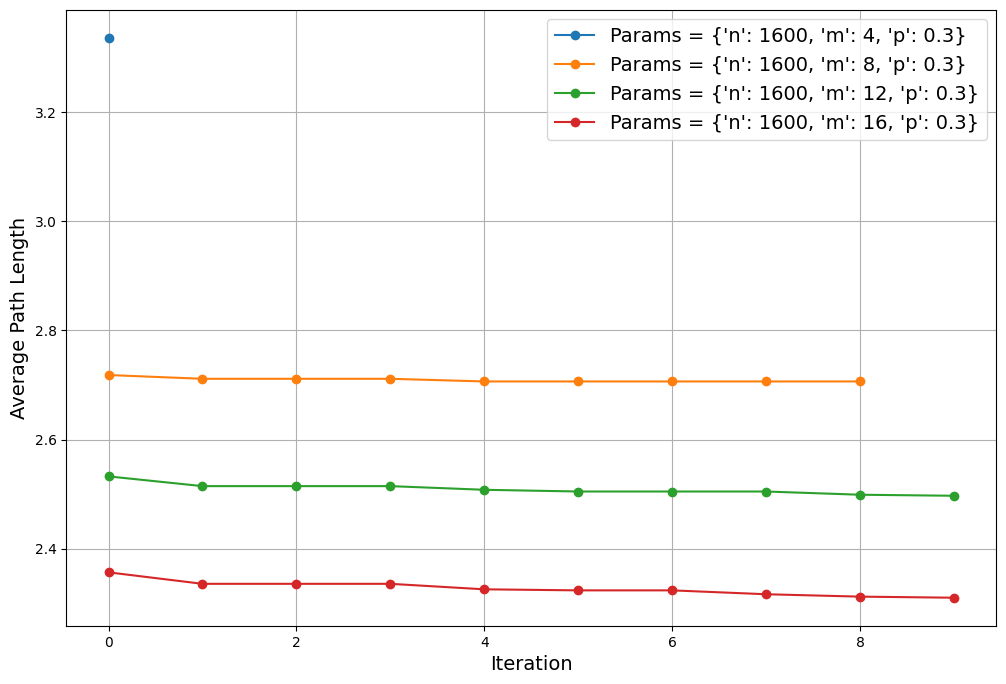

In [174]:
# Define base configuration
base_config = {
    'TP_percentage': 0.5,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'kde_models_dir': '/Applications/UNI/Thesis/saved_data/',
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'seed': 42
}

watts_strogatz_config = base_config.copy()
watts_strogatz_config.update({
    'network_type': 'watts_strogatz',
    'network_params': {
        'n': 1600,
        'k': 8,
        'p': 0.3
    }
})


barabasi_albert_config = base_config.copy()
barabasi_albert_config.update({
    'network_type': 'barabasi_albert',
    'network_params': {
        'n': 1600,
        'm': 8
    }
})

random_regular_config = base_config.copy()
random_regular_config.update({
    'network_type': 'random_regular',
    'network_params': {
        'n': 1600,
        'd': 8
    }
})

holme_kim_config = base_config.copy()
holme_kim_config.update({
    'network_type': 'holme_kim',
    'network_params': {
        'n': 1600,
        'm': 8,
        'p': 0.3
    }
})


network_configs = {
    'Watts-Strogatz': watts_strogatz_config,
    'Barabasi-Albert': barabasi_albert_config,
    'Random Regular': random_regular_config,
    'Holme-Kim': holme_kim_config
}
# Run the simulations and plot the results
num_simulations = 1
num_steps = 10

network_param_values = {
    'watts_strogatz': [{'n': 1600, 'k': k, 'p': 0.3} for k in [4, 8, 12, 16]],
    'barabasi_albert': [{'n': 1600, 'm': m} for m in [4, 8, 12, 16]],
    'random_regular': [{'n': 1600, 'd': d} for d in [4, 8, 12, 16]],
    'holme_kim': [{'n': 1600, 'm': m, 'p': 0.3} for m in [4, 8, 12, 16]],
}

network_configs = create_network_configs(base_config, network_param_values)

network_param_results = run_simulations_for_network_params(network_configs, num_steps, num_simulations)

# Plot results for Watts-Strogatz
ws_results = network_param_results['watts_strogatz']
plot_adoption_rates_for_network_params(ws_results, 'Watts-Strogatz')
plot_network_metrics_for_network_params(ws_results, 'Watts-Strogatz')

# Plot results for Barabasi-Albert
ba_results = network_param_results['barabasi_albert']
plot_adoption_rates_for_network_params(ba_results, 'Barabasi-Albert')
plot_network_metrics_for_network_params(ba_results, 'Barabasi-Albert')

# Plot results for Random Regular
rr_results = network_param_results['random_regular']
plot_adoption_rates_for_network_params(rr_results, 'Random Regular')
plot_network_metrics_for_network_params(rr_results, 'Random Regular')

# Plot results for Holme-Kim
hk_results = network_param_results['holme_kim']
plot_adoption_rates_for_network_params(hk_results, 'Holme-Kim')
plot_network_metrics_for_network_params(hk_results, 'Holme-Kim')

In [175]:
def plot_network_metrics_for_network_params(results, network_type, save_dir='./'):
    metrics = ['Average Degree', 'Variance of Degree', 'Average Clustering', 'Average Path Length']
    for metric in metrics:
        plt.figure(figsize=(12, 8))
        for param_str, simulation_data in results.items():
            steps = range(len(simulation_data[0][2][metric]))
            for _, _, metric_data in simulation_data:
                plt.plot(steps, metric_data[metric], label=f'Params = {param_str}', marker='o')
        plt.xlabel('Iteration', fontsize=14)
        plt.ylabel(metric, fontsize=14)
        plt.legend(fontsize = 14)
        plt.grid(True)
        filename = f"{save_dir}{network_type}_{metric.replace(' ', '_').lower()}_new.png"
        plt.savefig(filename)
        plt.close()
        #plt.show()

def plot_adoption_rates_for_network_params(results, network_type, save_dir='./'):
    plt.figure(figsize=(12, 8))
    for param_str, simulation_data in results.items():
        for model_data, _, _ in simulation_data:
            plt.plot(model_data['Adoption Rates'], label=f'Params = {param_str}', marker = "o")
    plt.xlabel('Iteration', fontsize=14)
    plt.ylabel('True Price Adoption Rate (%)', fontsize=14)
    plt.ylim(0, 100)
    plt.legend(fontsize = 14)
    plt.grid(True)
    filename = f"{save_dir}{network_type}_adoption_rates_new.png"
    plt.savefig(filename)
    plt.close()
    #plt.show()


In [176]:


plot_adoption_rates_for_network_params(ws_results, 'Watts-Strogatz')
plot_network_metrics_for_network_params(ws_results, 'Watts-Strogatz')

# Plot results for Barabasi-Albert
plot_adoption_rates_for_network_params(ba_results, 'Barabasi-Albert')
plot_network_metrics_for_network_params(ba_results, 'Barabasi-Albert')

# Plot results for Random Regular
plot_adoption_rates_for_network_params(rr_results, 'Random Regular')
plot_network_metrics_for_network_params(rr_results, 'Random Regular')

# Plot results for Holme-Kim
plot_adoption_rates_for_network_params(hk_results, 'Holme-Kim')
plot_network_metrics_for_network_params(hk_results, 'Holme-Kim')

In [177]:
# Define base configuration
base_config = {
    'TP_percentage': 0.5,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'kde_models_dir': '/Applications/UNI/Thesis/saved_data/',
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'seed': 42
}

watts_strogatz_config = base_config.copy()
watts_strogatz_config.update({
    'network_type': 'watts_strogatz',
    'network_params': {
        'n': 1600,
        'k': 8,
        'p': 0.3
    }
})


barabasi_albert_config = base_config.copy()
barabasi_albert_config.update({
    'network_type': 'barabasi_albert',
    'network_params': {
        'n': 1600,
        'm': 8
    }
})

random_regular_config = base_config.copy()
random_regular_config.update({
    'network_type': 'random_regular',
    'network_params': {
        'n': 1600,
        'd': 8
    }
})

holme_kim_config = base_config.copy()
holme_kim_config.update({
    'network_type': 'holme_kim',
    'network_params': {
        'n': 1600,
        'm': 8,
        'p': 0.3
    }
})


network_configs = {
    'Watts-Strogatz': watts_strogatz_config,
    'Barabasi-Albert': barabasi_albert_config,
    'Random Regular': random_regular_config,
    'Holme-Kim': holme_kim_config
}
# Run the simulations and plot the results
num_simulations = 1
num_steps = 10

network_param_values = {
    'watts_strogatz': [{'n': 1600, 'k': 8, 'p': p} for p in [0, 0.2, 0.4, 0.6, 0.8, 1]],
    'holme_kim': [{'n': 1600, 'm': 8, 'p': p} for p in [0, 0.2, 0.4, 0.6, 0.8, 1]]
}

network_configs = create_network_configs(base_config, network_param_values)

def plot_network_metrics_for_network_params(results, network_type, save_dir='./'):
    metrics = ['Average Degree', 'Variance of Degree', 'Average Clustering', 'Average Path Length']
    for metric in metrics:
        plt.figure(figsize=(12, 8))
        for param_str, simulation_data in results.items():
            steps = range(len(simulation_data[0][2][metric]))
            for _, _, metric_data in simulation_data:
                plt.plot(steps, metric_data[metric], label=f'Params = {param_str}', marker='o')
        plt.xlabel('Iteration', fontsize=14)
        plt.ylabel(metric, fontsize=14)
        plt.legend(fontsize = 14)
        plt.grid(True)
        filename = f"{save_dir}{network_type}_{metric.replace(' ', '_').lower()}_p.png"
        plt.savefig(filename)
        plt.close()
        #plt.show()

def plot_adoption_rates_for_network_params(results, network_type, save_dir='./'):
    plt.figure(figsize=(12, 8))
    for param_str, simulation_data in results.items():
        for model_data, _, _ in simulation_data:
            plt.plot(model_data['Adoption Rates'], label=f'Params = {param_str}', marker = "o")
    plt.xlabel('Iteration', fontsize=14)
    plt.ylabel('True Price Adoption Rate (%)', fontsize=14)
    plt.ylim(0, 100)
    plt.legend(fontsize = 14)
    plt.grid(True)
    filename = f"{save_dir}{network_type}_adoption_rates_p.png"
    plt.savefig(filename)
    plt.close()
    #plt.show()


network_param_results = run_simulations_for_network_params(network_configs, num_steps, num_simulations)

# Plot results for Watts-Strogatz
ws_results = network_param_results['watts_strogatz']
plot_adoption_rates_for_network_params(ws_results, 'Watts-Strogatz')
plot_network_metrics_for_network_params(ws_results, 'Watts-Strogatz')

# Plot results for Holme-Kim
hk_results = network_param_results['holme_kim']
plot_adoption_rates_for_network_params(hk_results, 'Holme-Kim')
plot_network_metrics_for_network_params(hk_results, 'Holme-Kim')

Simulation Progress: 100%|██████████| 10/10 [01:05<00:00,  6.60s/it]


## Global Sensitivity Analysis

Sobol indices

Saltelli sampling

Pick key parameters (e.g. alpha, beta, rewiring probability) and key measures (true price adoption rate...)

In [10]:


network_problems = {
    'Watts-Strogatz': {
        'num_vars': 7,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'min_increase_percentage','max_increase_percentage', 'k', 'p'],
        'bounds': [[0, 1], [0, 1], [0, 1],  [1,10], [11,20], [2, 10], [0, 1]] 
    },
    'Barabasi-Albert': {
        'num_vars': 6,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold','min_increase_percentage', 'max_increase_percentage', 'm'],
        'bounds': [[0, 1], [0, 1], [0, 1], [1,10], [11,20],[2, 10]]  
    },
    'Random Regular': {
        'num_vars': 6,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold','min_increase_percentage','max_increase_percentage','d'],
        'bounds': [[0, 1], [0, 1], [0, 1], [1,10], [11,20],[2, 10]]  
    },
    'Holme-Kim': {
        'num_vars': 7,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'min_increase_percentage','max_increase_percentage','m', 'p'],
        'bounds': [[0, 1], [0, 1], [0, 1],[1,10], [11,20],[2, 10], [0, 1]] 
    }
}

In [11]:
num_samples = 256

samples = {}
for network_name, problem in network_problems.items():
    samples[network_name] = saltelli.sample(problem, num_samples)


/var/folders/53/cl5y6r2x7n5_942j6h59yyh00000gn/T/ipykernel_2264/3049819496.py:7: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  samples[network_name] = saltelli.sample(problem, num_samples)


In [12]:

def collect_simulation_data(model, num_steps):
    collected_data = {
        'Step': [],
        'Adoption Rate': [],
        'Avg_F_Satisfaction': [],
        'Avg_S_Satisfaction': [],
        'Avg_P_Satisfaction': [],
        'Avg_F_Uncertainty': [],
        'Avg_S_Uncertainty': [],
        'Avg_P_Uncertainty': []
    }

    for step in range(num_steps):
        model.step()
        collected_data['Step'].append(step)
        collected_data['Adoption Rate'].append(model.calculate_true_price_adoption_rate())
        collected_data['Avg_F_Satisfaction'].append(np.mean([agent.F_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_S_Satisfaction'].append(np.mean([agent.S_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_P_Satisfaction'].append(np.mean([agent.P_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_F_Uncertainty'].append(np.mean([agent.F_uncertainty for agent in model.schedule.agents]))
        collected_data['Avg_S_Uncertainty'].append(np.mean([agent.S_uncertainty for agent in model.schedule.agents]))
        collected_data['Avg_P_Uncertainty'].append(np.mean([agent.P_uncertainty for agent in model.schedule.agents]))

    model_data = pd.DataFrame(collected_data)
    return model_data

def run_single_simulation(params, config, network_name, num_steps):
    config = config.copy()
    config['TP_percentage'] = params[0]
    config['satisfaction_threshold'] = params[1]
    config['uncertainty_threshold'] = params[2]
    config['min_increase_percentage'] = params[3]
    config['max_increase_percentage'] = params[4]


    if network_name == 'Watts-Strogatz':
        config['network_params']['k'] = int(params[5])
        config['network_params']['p'] = params[6]
    elif network_name == 'Barabasi-Albert':
        config['network_params']['m'] = int(params[5])
    elif network_name == 'Random Regular':
        config['network_params']['d'] = int(params[5])
    elif network_name == 'Holme-Kim':
        config['network_params']['m'] = int(params[5])
        config['network_params']['p'] = params[6]

    model = ConsumatModel(config)
    model_data = collect_simulation_data(model, num_steps)
    final_step_data = model_data.iloc[-1]

    return [
        final_step_data['Adoption Rate'],
        final_step_data['Avg_F_Satisfaction'],
        final_step_data['Avg_S_Satisfaction'],
        final_step_data['Avg_P_Satisfaction'],
        final_step_data['Avg_F_Uncertainty'],
        final_step_data['Avg_S_Uncertainty'],
        final_step_data['Avg_P_Uncertainty']
    ]

def run_gsa_simulation_parallel(network_name, config, samples, num_steps, n_jobs=-1):
    all_results = Parallel(n_jobs=n_jobs)(
        delayed(run_single_simulation)(params, config, network_name, num_steps)
        for params in tqdm(samples, desc=f'Running simulations for {network_name}')
    )
    return np.array(all_results)

num_steps = 10

for network_name, config in network_configurations.items():
    print(f"Running GSA for {network_name} network...")
    config = base_config.copy()  
    config.update(network_configurations[network_name])
    all_results = run_gsa_simulation_parallel(network_name, config, samples[network_name], num_steps)
    
    results = {}
    
    for i, output in enumerate(['Adoption Rate', 'Avg_F_Satisfaction', 'Avg_S_Satisfaction', 'Avg_P_Satisfaction', 'Avg_F_Uncertainty', 'Avg_S_Uncertainty', 'Avg_P_Uncertainty']):
        Si = sobol.analyze(network_problems[network_name], all_results[:, i], print_to_console=True)
        results[output] = {
            'S1': Si['S1'].tolist(),
            'ST': Si['ST'].tolist(),
            'S1_conf': Si['S1_conf'].tolist(),
            'ST_conf': Si['ST_conf'].tolist()
        }
        print(f'Sensitivity analysis for {output} ({network_name} network):')
        print(Si)
    
    with open(f'nohomphily_new_sensitivity_results_{network_name}.json', 'w') as f:
        json.dump(results, f)    
     



Running GSA for Watts-Strogatz network...


Running simulations for Watts-Strogatz: 100%|██████████| 4096/4096 [2:34:13<00:00,  2.26s/it]  


                               ST   ST_conf
TP_percentage            1.017158  0.147250
satisfaction_threshold   0.223661  0.082378
uncertainty_threshold    0.201194  0.074459
min_increase_percentage  0.193815  0.073759
max_increase_percentage  0.139026  0.073992
k                        0.202957  0.083096
p                        0.160992  0.065680
                               S1   S1_conf
TP_percentage            0.809443  0.155964
satisfaction_threshold   0.054961  0.091045
uncertainty_threshold    0.001268  0.080288
min_increase_percentage  0.014665  0.071576
max_increase_percentage  0.058509  0.068831
k                        0.058704  0.084813
p                        0.046219  0.071037
                                                          S2   S2_conf
(TP_percentage, satisfaction_threshold)            -0.159487  0.169416
(TP_percentage, uncertainty_threshold)             -0.057897  0.134614
(TP_percentage, min_increase_percentage)           -0.069063  0.137054
(TP_percenta

Running simulations for Barabasi-Albert: 100%|██████████| 3584/3584 [7:31:09<00:00,  7.55s/it]  


                               ST   ST_conf
TP_percentage            0.830005  0.128456
satisfaction_threshold   0.243946  0.076442
uncertainty_threshold    0.385198  0.106221
min_increase_percentage  0.132169  0.080425
max_increase_percentage  0.119769  0.063504
m                        0.163561  0.073316
                               S1   S1_conf
TP_percentage            0.536010  0.150413
satisfaction_threshold  -0.009299  0.077438
uncertainty_threshold    0.063167  0.112518
min_increase_percentage -0.039232  0.055734
max_increase_percentage -0.014504  0.053730
m                       -0.024590  0.066617
                                                          S2   S2_conf
(TP_percentage, satisfaction_threshold)             0.105226  0.168150
(TP_percentage, uncertainty_threshold)              0.125955  0.169616
(TP_percentage, min_increase_percentage)            0.019987  0.166788
(TP_percentage, max_increase_percentage)            0.028541  0.147824
(TP_percentage, m)           

Running simulations for Random Regular: 100%|██████████| 3584/3584 [4:43:54<00:00,  4.75s/it]  


                               ST   ST_conf
TP_percentage            0.996011  0.138358
satisfaction_threshold   0.138685  0.051723
uncertainty_threshold    0.203250  0.075812
min_increase_percentage  0.100779  0.052847
max_increase_percentage  0.111354  0.056128
d                        0.105149  0.043563
                               S1   S1_conf
TP_percentage            0.755862  0.153873
satisfaction_threshold  -0.002942  0.060083
uncertainty_threshold    0.012819  0.064002
min_increase_percentage  0.037784  0.056658
max_increase_percentage  0.041018  0.059377
d                        0.020603  0.055653
                                                          S2   S2_conf
(TP_percentage, satisfaction_threshold)             0.048046  0.103538
(TP_percentage, uncertainty_threshold)              0.079224  0.102979
(TP_percentage, min_increase_percentage)           -0.011356  0.123827
(TP_percentage, max_increase_percentage)           -0.006567  0.092995
(TP_percentage, d)           

Running simulations for Holme-Kim: 100%|██████████| 4096/4096 [5:52:39<00:00,  5.17s/it]  


                               ST   ST_conf
TP_percentage            0.778160  0.120530
satisfaction_threshold   0.290503  0.091399
uncertainty_threshold    0.356289  0.088521
min_increase_percentage  0.193653  0.079676
max_increase_percentage  0.230264  0.085710
m                        0.212742  0.084252
p                        0.196408  0.086742
                               S1   S1_conf
TP_percentage            0.583857  0.135136
satisfaction_threshold   0.076119  0.085192
uncertainty_threshold    0.112309  0.092369
min_increase_percentage  0.076345  0.068080
max_increase_percentage  0.063932  0.075814
m                        0.044828  0.087398
p                        0.072295  0.075401
                                                          S2   S2_conf
(TP_percentage, satisfaction_threshold)            -0.161615  0.172928
(TP_percentage, uncertainty_threshold)             -0.039248  0.168172
(TP_percentage, min_increase_percentage)           -0.218371  0.157796
(TP_percenta